In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA


import antares_client

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# set random seed for consistent results
import random
random.seed(0)

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [6]:
#dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_90k_tns_df.csv', index_col='ztf_object_id')
dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df_SMOTE.csv.gz', compression='gzip', index_col='ztf_object_id')

dataset_bank_tns_df

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF17aaahrni,1.501946,-0.235464,0.333333,0.000000,0.300476,3.003893,2.881442,1.473296,-0.318407,0.000616,...,-0.071001,0.051300,-0.024000,-0.145601,22.882911,2.639232,Yes_TNS,None,-99.000,GaiaAlerts
ZTF17aadqidc,0.118791,-0.558108,0.428571,0.000000,0.385504,0.237581,0.223594,0.138365,-0.746279,0.013288,...,0.163198,0.160099,0.150101,0.122200,26.155457,0.051662,No_TNS,None,-99.000,None
ZTF18aabdnbr,0.284822,-1.081973,0.500000,0.000000,0.356579,0.569645,0.569645,0.341098,0.658685,-0.058917,...,1.009100,0.966900,1.035601,0.759600,29.581593,0.134794,Yes_TNS,None,-99.000,ALeRCE
ZTF18aabeszt,0.863825,-0.432979,0.352941,0.242536,0.402415,1.727650,1.124861,0.719469,0.015570,0.011897,...,1.377100,1.417500,1.326600,1.264300,13.694428,0.155972,Yes_TNS,SN Ia,0.081,ALeRCE
ZTF18aabvmws,0.688205,-0.229184,0.200000,0.000000,0.351717,1.376410,1.376410,0.465530,2.176836,0.002681,...,0.928100,1.152900,1.095700,1.077000,146.660175,0.027380,Yes_TNS,None,-99.000,ZTF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTFabc31718,1.119946,0.090593,0.367584,0.156322,0.398276,2.104855,1.491006,0.772174,-0.491650,0.004334,...,0.089421,0.171838,0.114570,-0.014704,3.297481,0.060415,Fake,TDE,-99.000,None
ZTFabc95168,1.129860,0.077758,0.318959,0.151432,0.388470,2.249870,1.683221,0.608025,-0.415222,0.006912,...,0.127524,0.237286,0.211414,0.080685,2.848608,0.079126,Fake,TDE,-99.000,None
ZTFabc63856,0.766622,-0.305970,0.353075,0.000000,0.385678,1.533244,1.362923,0.766964,0.334027,-0.009245,...,0.507876,0.656177,0.784915,0.666776,26.167791,0.027966,Fake,TDE,-99.000,None


In [7]:
suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_sep_highlighted_SMOTE"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_sep_highlighted"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_LConly"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_noSS_AlerceCls_fw_MI_classif_LConly"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_noSS_AlerceCls_fw_MI_classif_only2"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after_MI_classif_only"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after_MI_classif_highlight_sepFs"
#suffix=f"noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after_fromDict"

ann_num = 350
col_list= [f'dist={col}' for col in range(1, ann_num)]
dist_col = f'Max-{len(col_list)}ANNs'


ann_dist_all_df = pd.read_csv(f'ann_dist_all_df_{suffix}_ann_num={ann_num}.csv', index_col=0)
ann_dist_all_df.index = ann_dist_all_df.index.rename('ztf_object_id')
ann_dist_all_df

,Mean-349ANNs,Max-349ANNs
ztf_object_id,,
ZTF17aaahrni,498.754540,578.464294
ZTF17aadqidc,398.215612,447.413361
ZTF18aabdnbr,591.637110,732.549011
ZTF18aabeszt,346.460165,400.535156
ZTF18aabvmws,357.428425,416.939362
...,...,...
ZTFabc99992,205.864851,320.651337
ZTFabc99993,336.852910,533.531982
ZTFabc99994,284.326388,317.863129


In [10]:
merge_df = pd.concat([ann_dist_all_df, dataset_bank_tns_df], axis=1)
merge_df = merge_df[~merge_df.isnull().any(axis=1)]
merge_df

,Mean-349ANNs,Max-349ANNs,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF17aaahrni,498.754540,578.464294,1.501946,-0.235464,0.333333,0.000000,0.300476,3.003893,2.881442,1.473296,...,-0.071001,0.051300,-0.024000,-0.145601,22.882911,2.639232,Yes_TNS,None,-99.000,GaiaAlerts
ZTF17aadqidc,398.215612,447.413361,0.118791,-0.558108,0.428571,0.000000,0.385504,0.237581,0.223594,0.138365,...,0.163198,0.160099,0.150101,0.122200,26.155457,0.051662,No_TNS,None,-99.000,None
ZTF18aabdnbr,591.637110,732.549011,0.284822,-1.081973,0.500000,0.000000,0.356579,0.569645,0.569645,0.341098,...,1.009100,0.966900,1.035601,0.759600,29.581593,0.134794,Yes_TNS,None,-99.000,ALeRCE
ZTF18aabeszt,346.460165,400.535156,0.863825,-0.432979,0.352941,0.242536,0.402415,1.727650,1.124861,0.719469,...,1.377100,1.417500,1.326600,1.264300,13.694428,0.155972,Yes_TNS,SN Ia,0.081,ALeRCE
ZTF18aabvmws,357.428425,416.939362,0.688205,-0.229184,0.200000,0.000000,0.351717,1.376410,1.376410,0.465530,...,0.928100,1.152900,1.095700,1.077000,146.660175,0.027380,Yes_TNS,None,-99.000,ZTF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTFabc99966,373.336265,446.534973,0.816064,0.117795,0.239689,0.089907,0.399810,1.632128,1.334600,0.795896,...,1.540607,1.282582,1.352111,1.491677,230.900417,0.724668,Fake,SN Ic-BL,-99.000,None
ZTFabc99967,228.168870,404.670502,0.489492,-0.154354,0.259923,0.059743,0.377112,0.978984,0.730363,0.350654,...,1.112523,1.300000,1.154665,1.168842,64.731008,0.855734,Fake,SN Ic-BL,-99.000,None
ZTFabc99985,217.095341,339.317657,0.874467,-0.245434,0.445352,0.072863,0.413493,1.748933,1.535292,1.071813,...,0.481378,0.426090,0.372378,0.324414,44.398133,0.131394,Fake,SN Ia-pec,-99.000,None


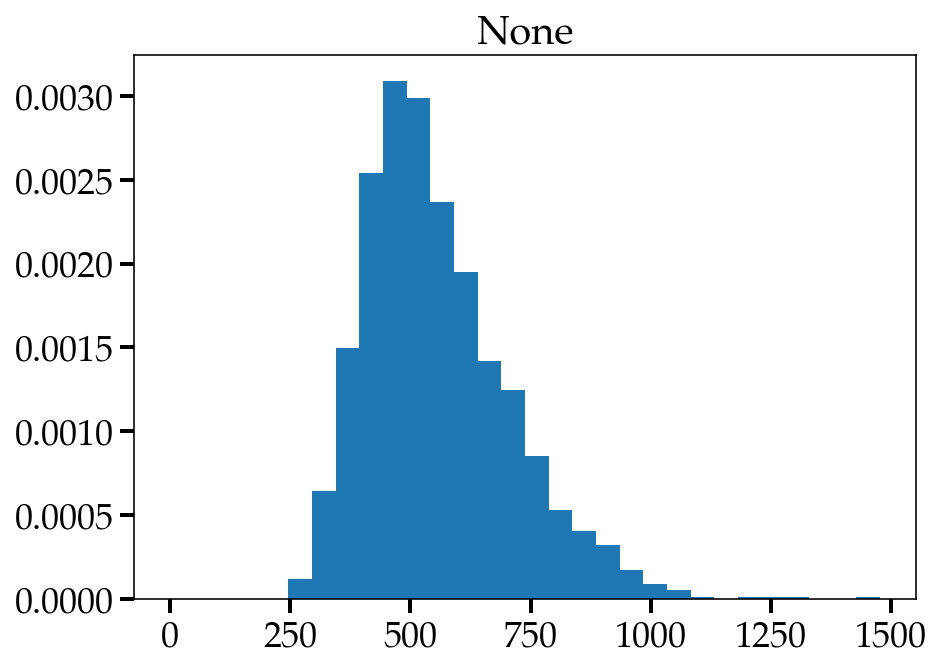

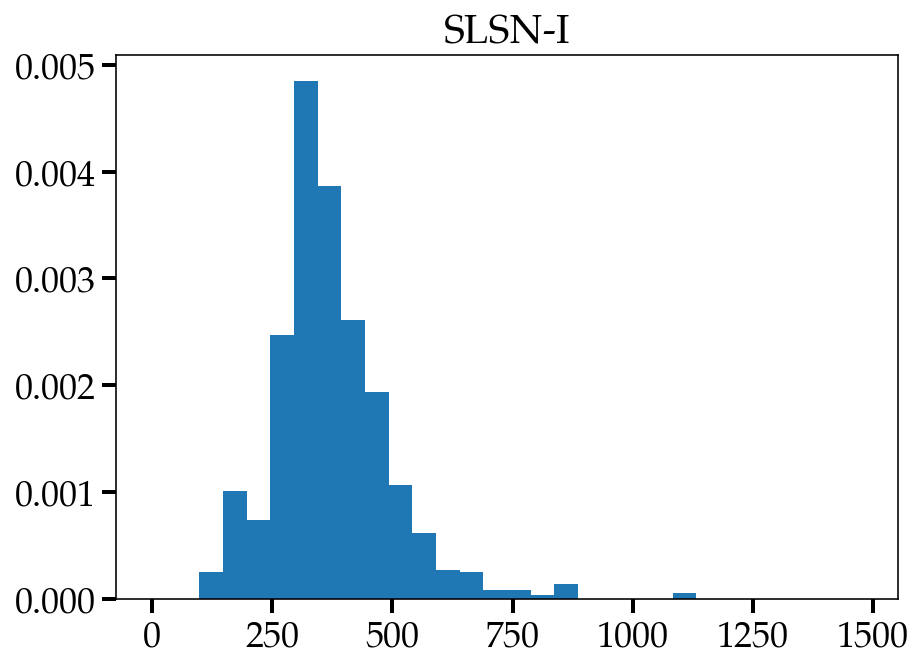

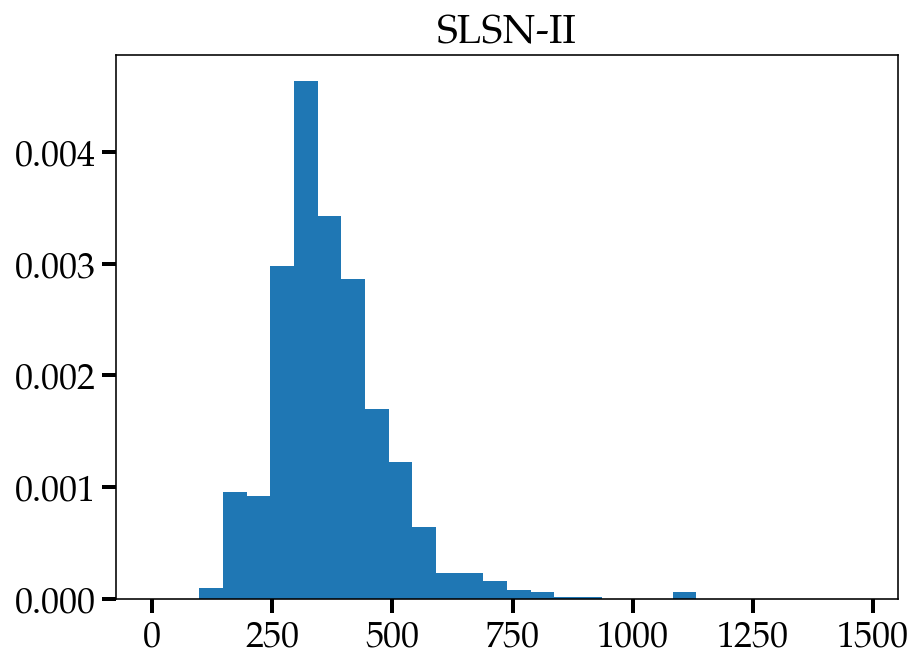

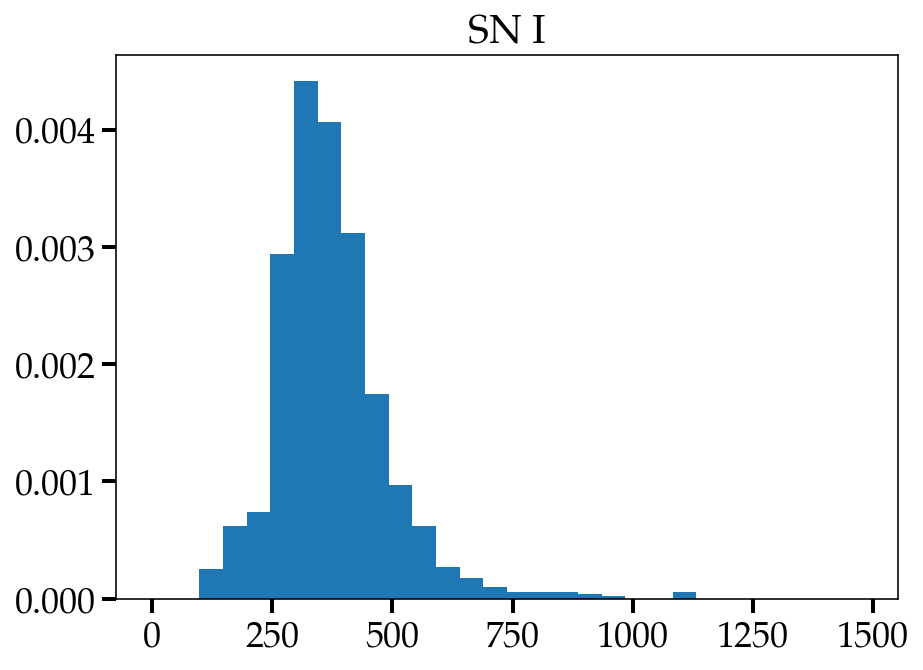

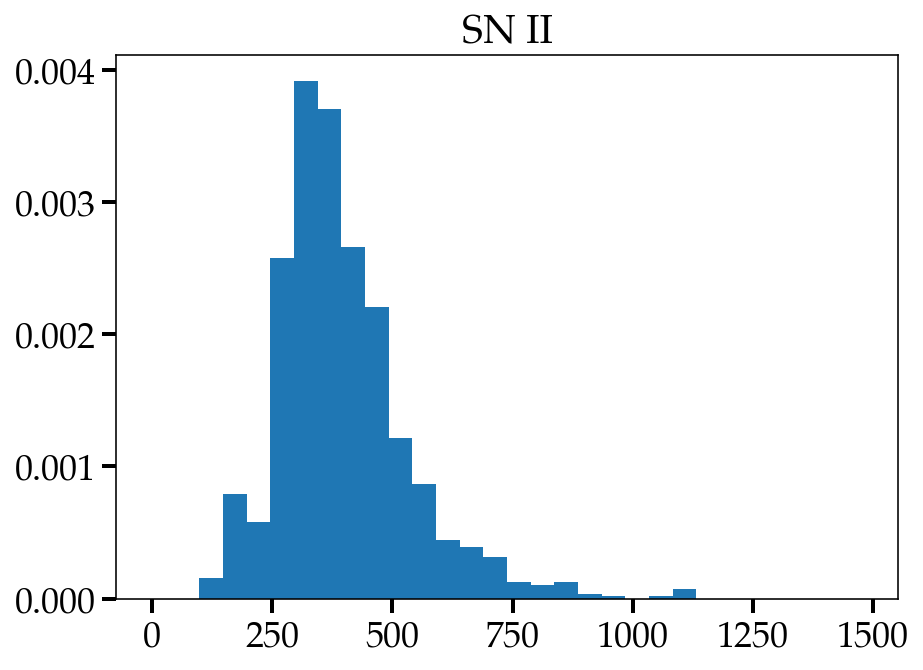

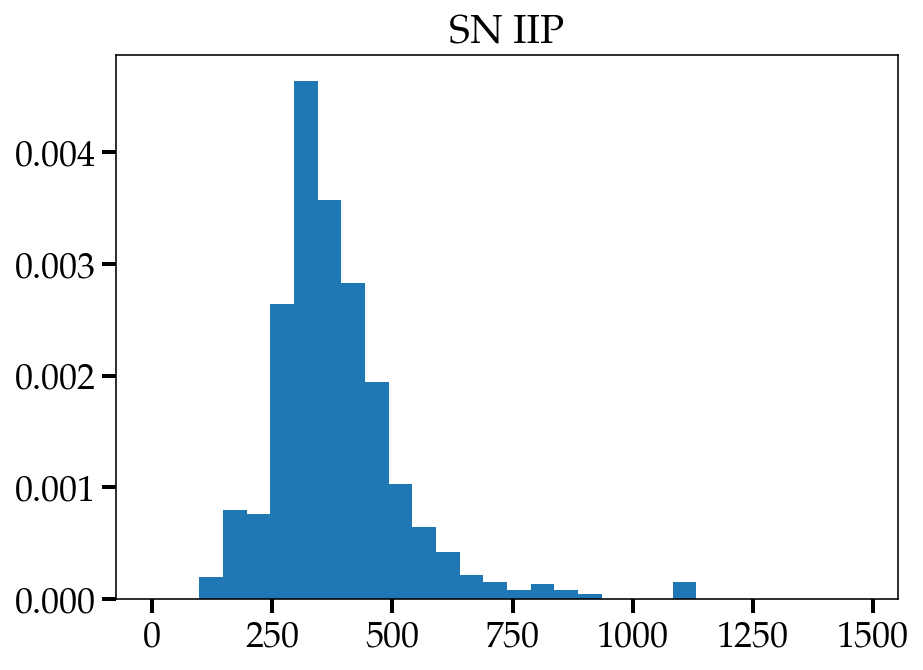

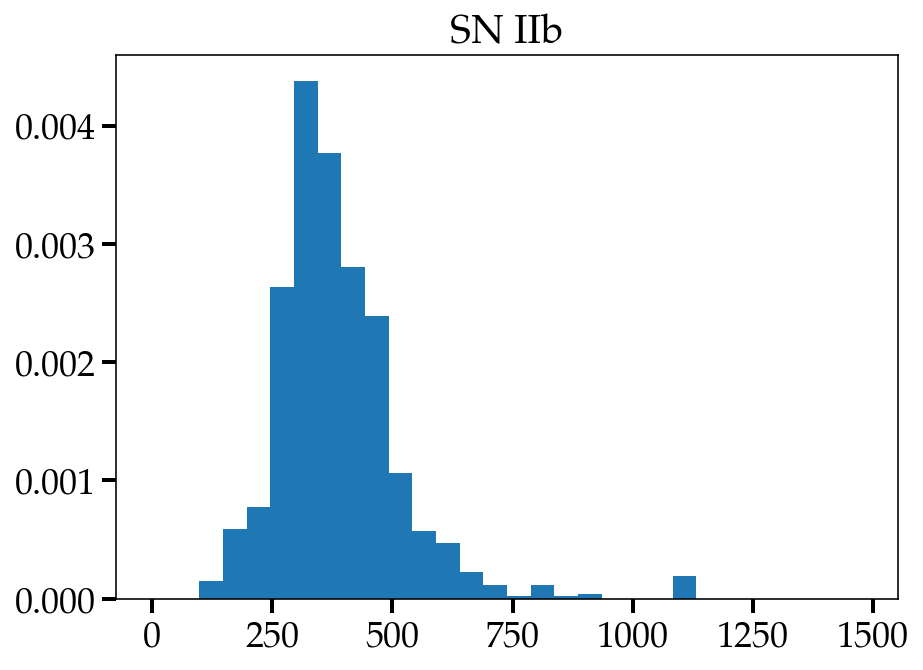

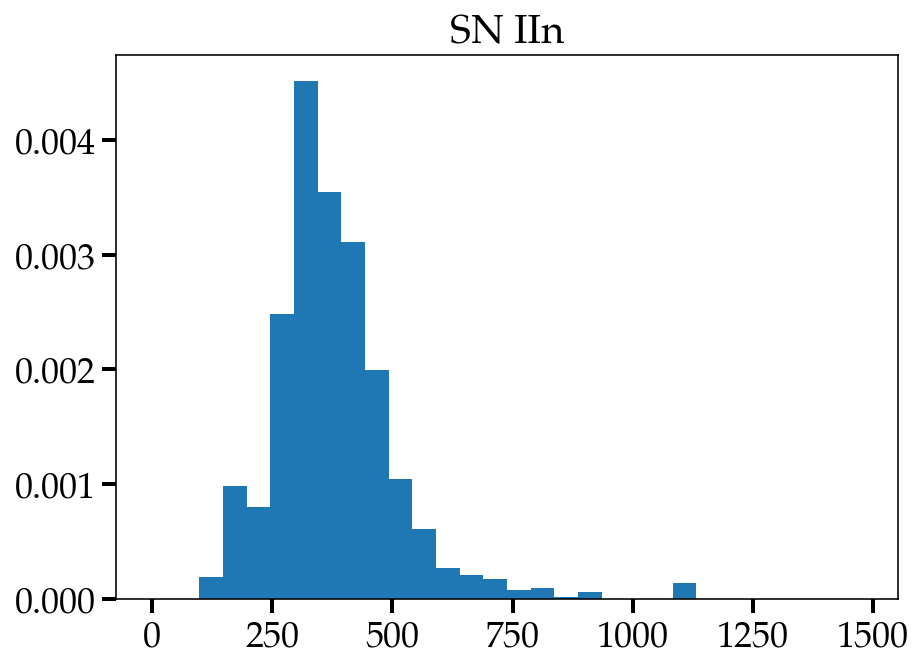

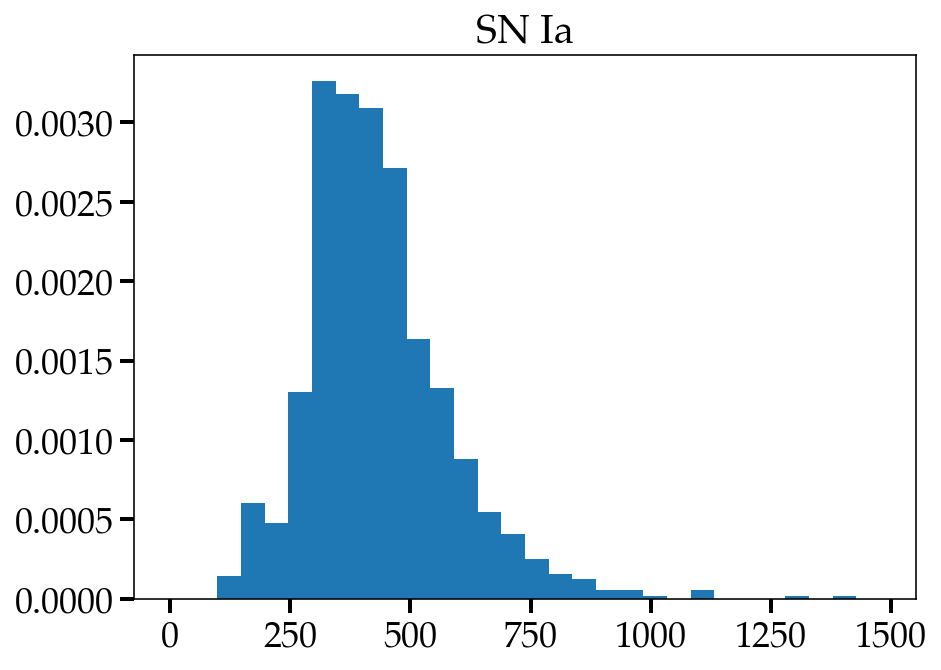

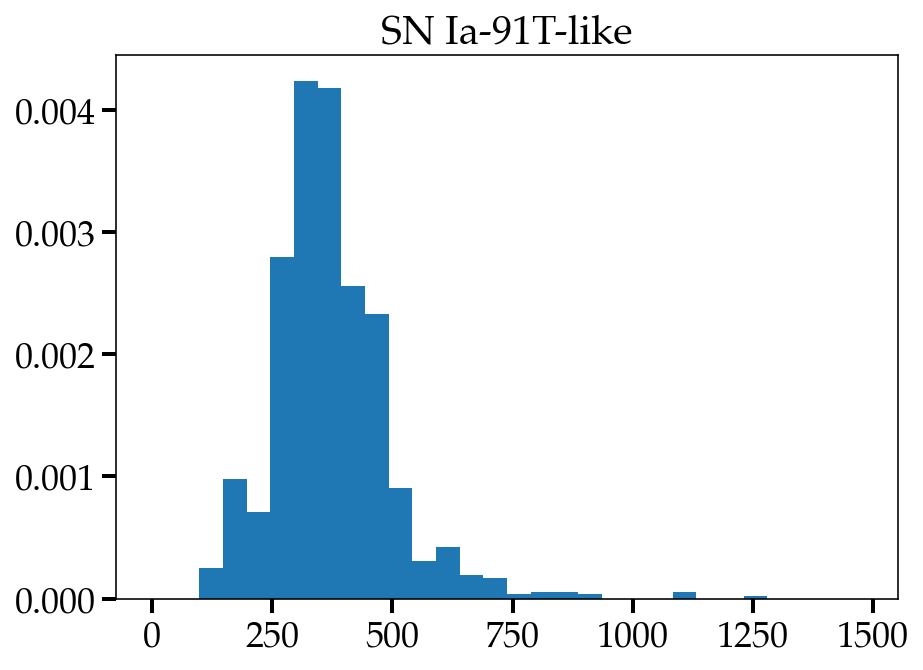

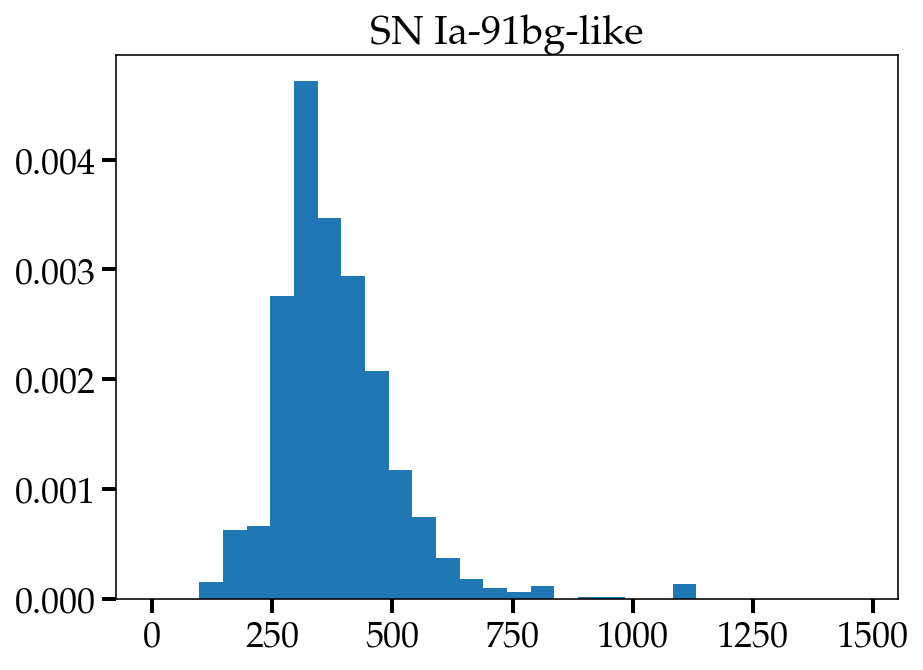

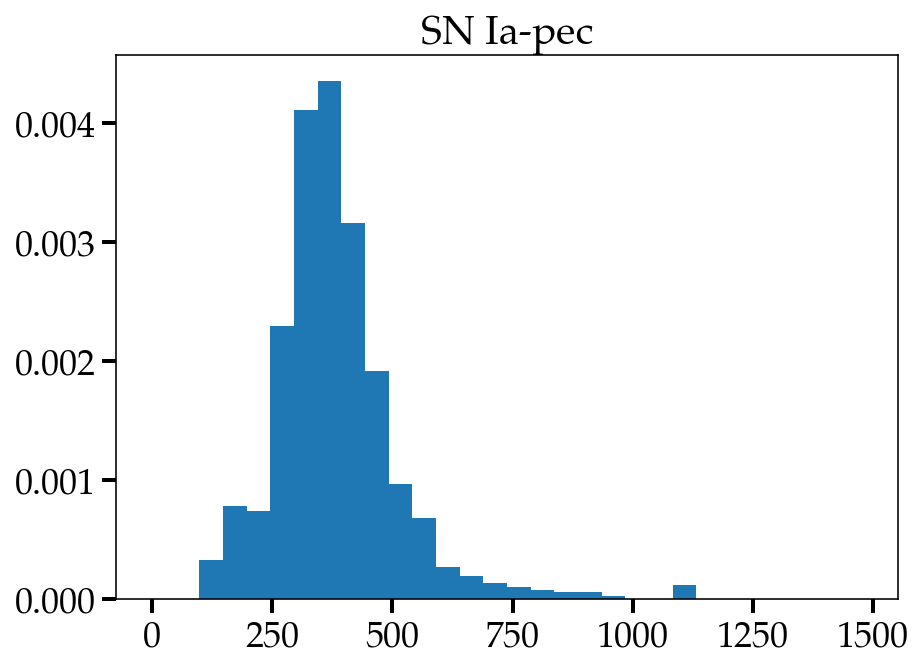

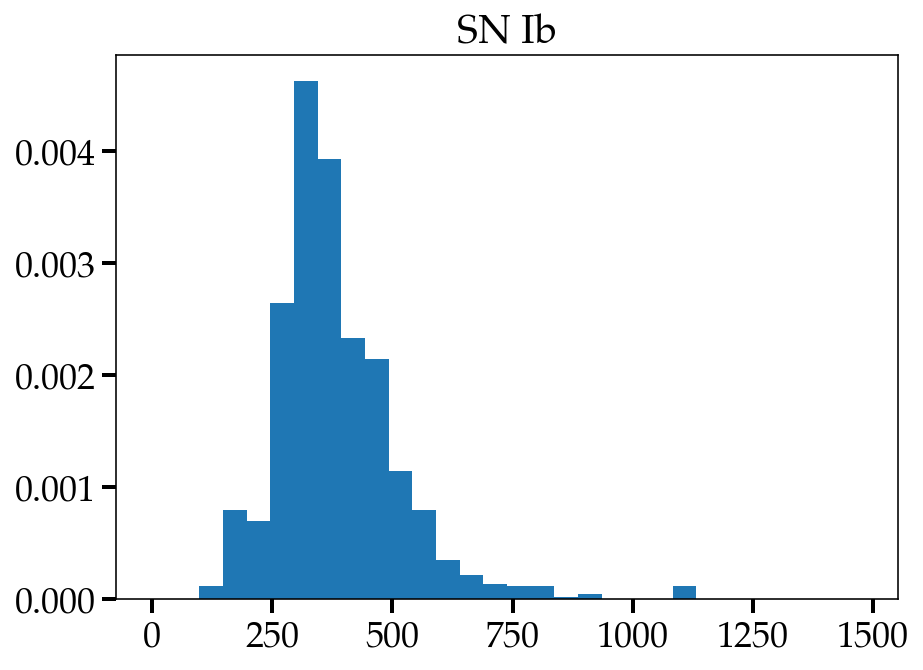

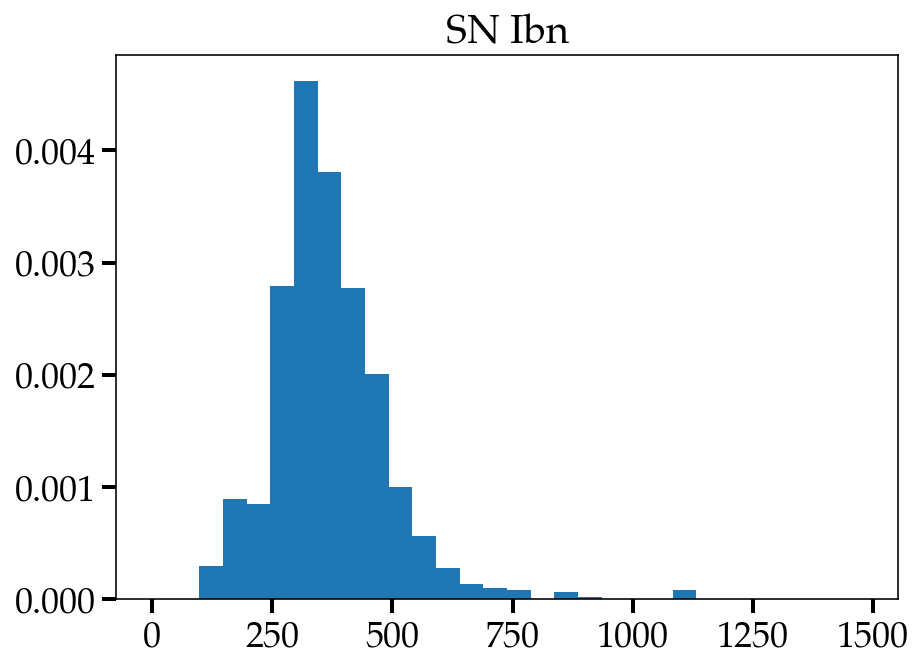

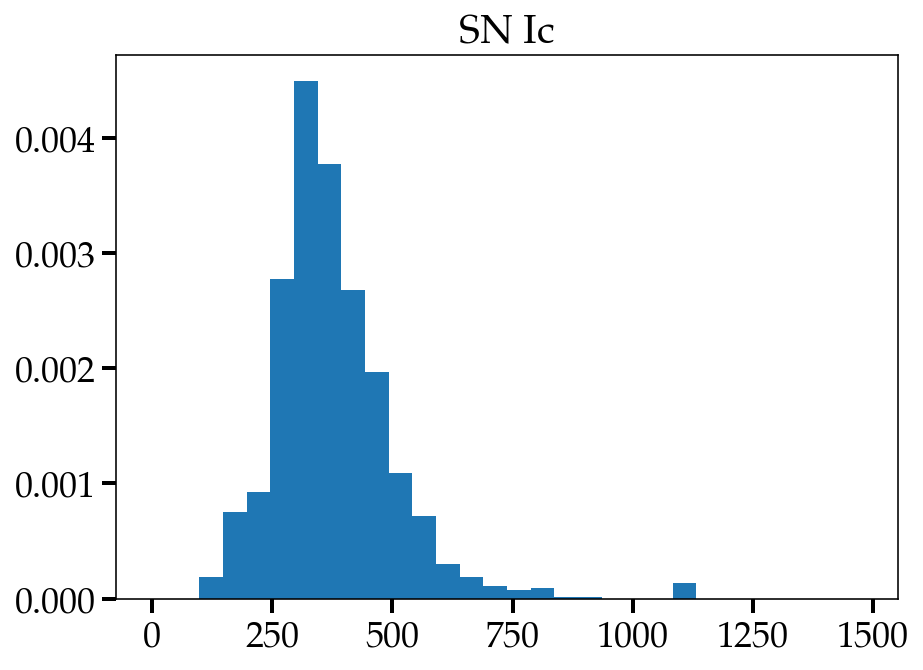

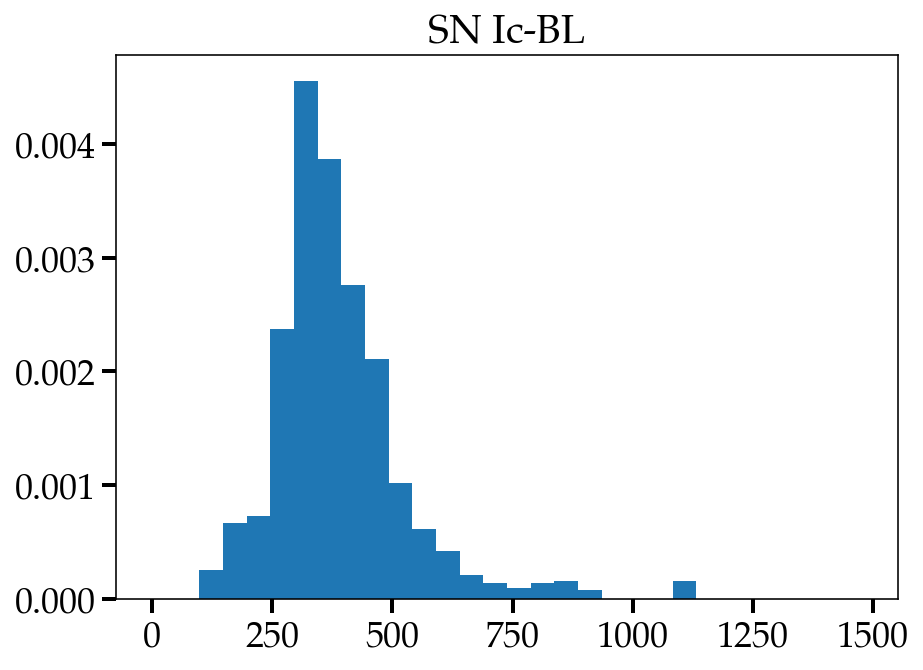

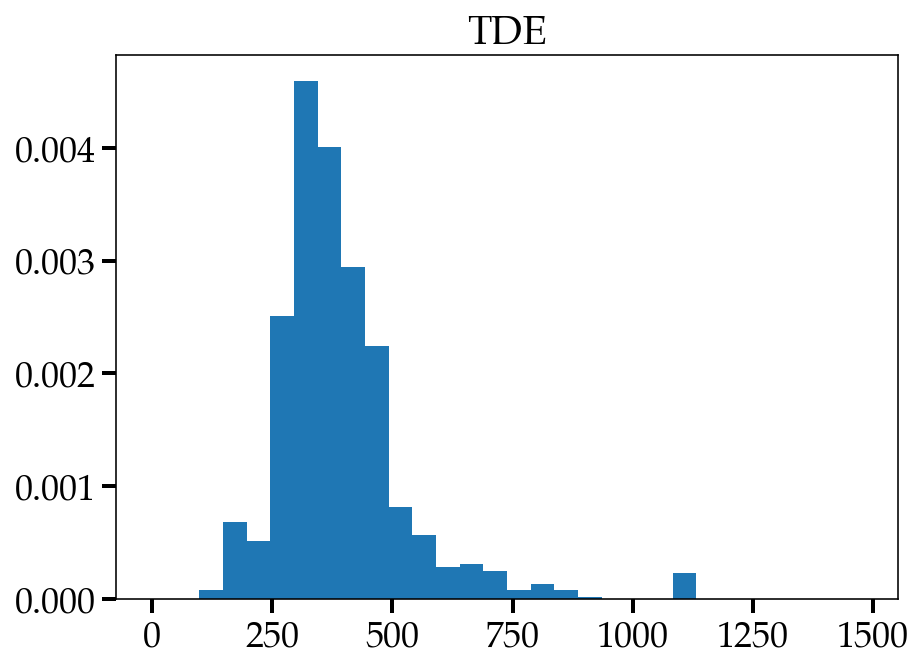

In [11]:
for cls in np.unique(merge_df.tns_cls):
    fig, ax = plt.subplots()
    
    merge_df_cls = merge_df[merge_df.tns_cls == cls]
    
    #ax.hist(merge_df_cls["WeightedMean-9ANNs"], bins=np.linspace(0, np.max(merge_df["WeightedMean-9ANNs"]), 31), density=True)
    ax.hist(merge_df_cls[dist_col], bins=np.linspace(0, np.max(merge_df[dist_col]), 31), density=True)
    
    ax.set_title(cls)
    #ax.set_xlim(0, 150)

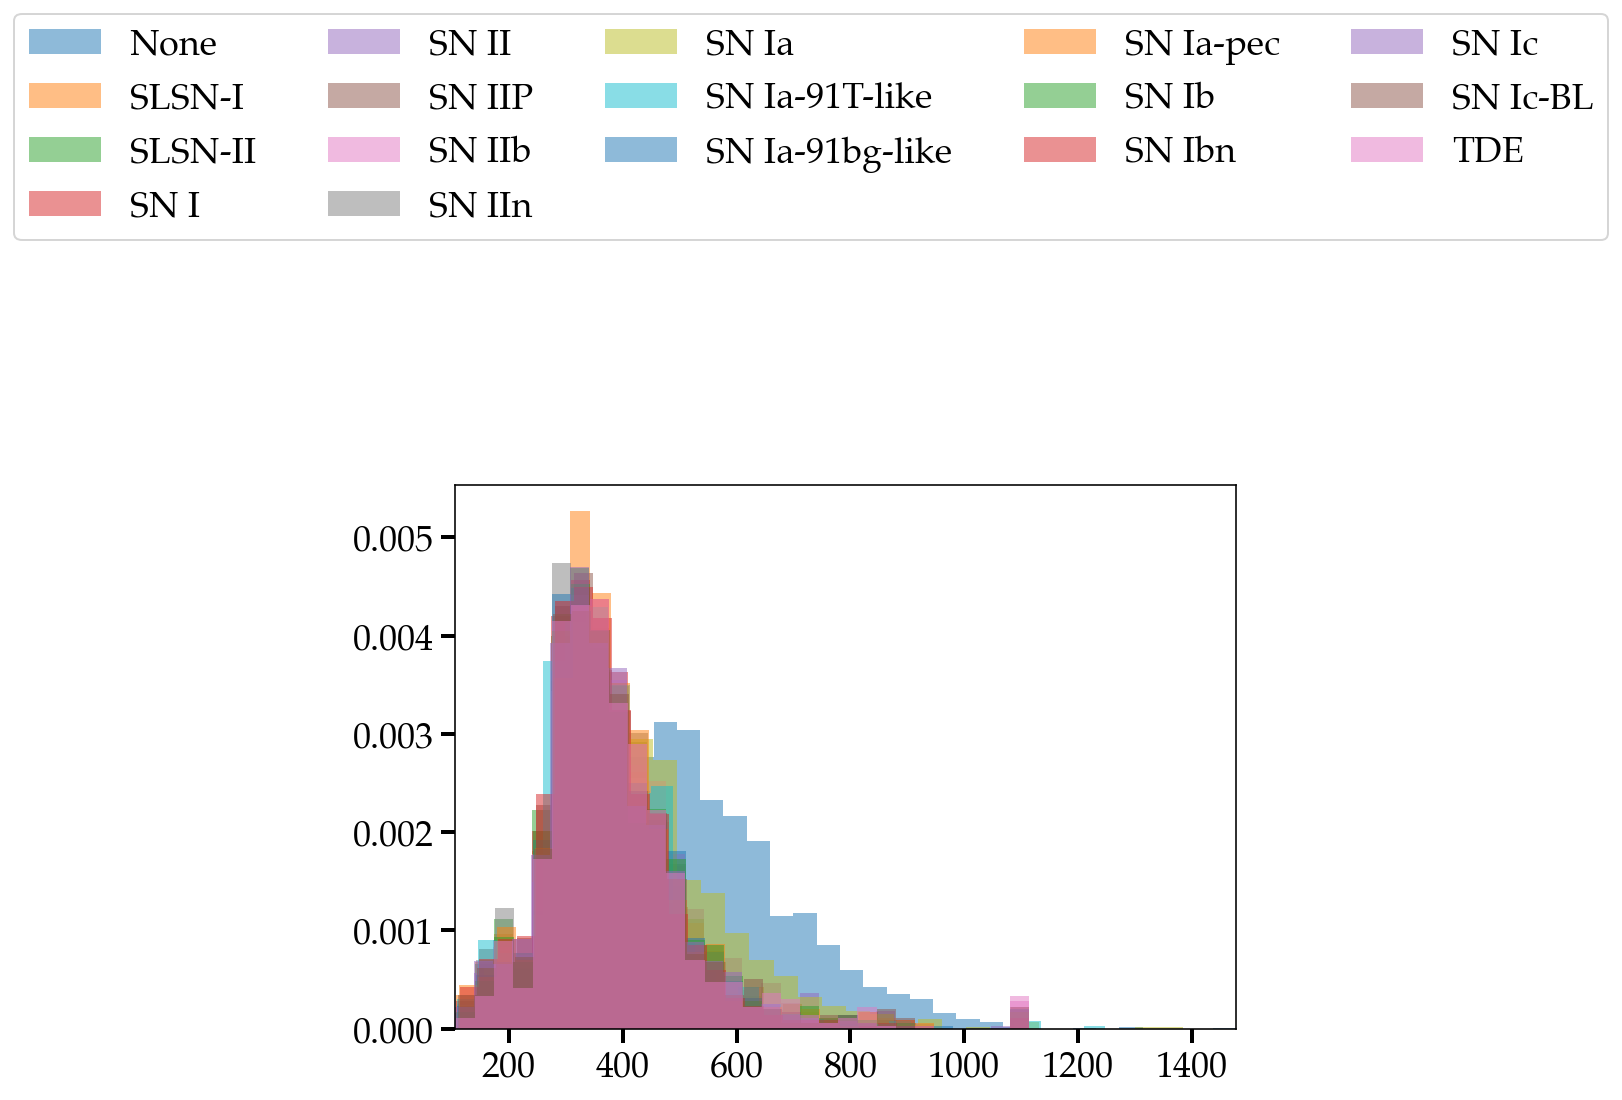

In [12]:
fig, ax = plt.subplots()

for cls in np.unique(merge_df.tns_cls):
    
    merge_df_cls = merge_df[merge_df.tns_cls == cls]
    
    #ax.hist(merge_df_cls["WeightedMean-9ANNs"], bins=np.linspace(0, 150, 31), 
    #        density=True, alpha=0.5, label=cls)
    
    ax.hist(merge_df_cls[dist_col], bins=np.linspace(np.min(merge_df_cls[dist_col]), np.max(merge_df_cls[dist_col]), 31), 
            density=True, alpha=0.5, label=cls)
    
plt.xlim(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]))
plt.legend(ncol=5, bbox_to_anchor=(1.5,1.9))

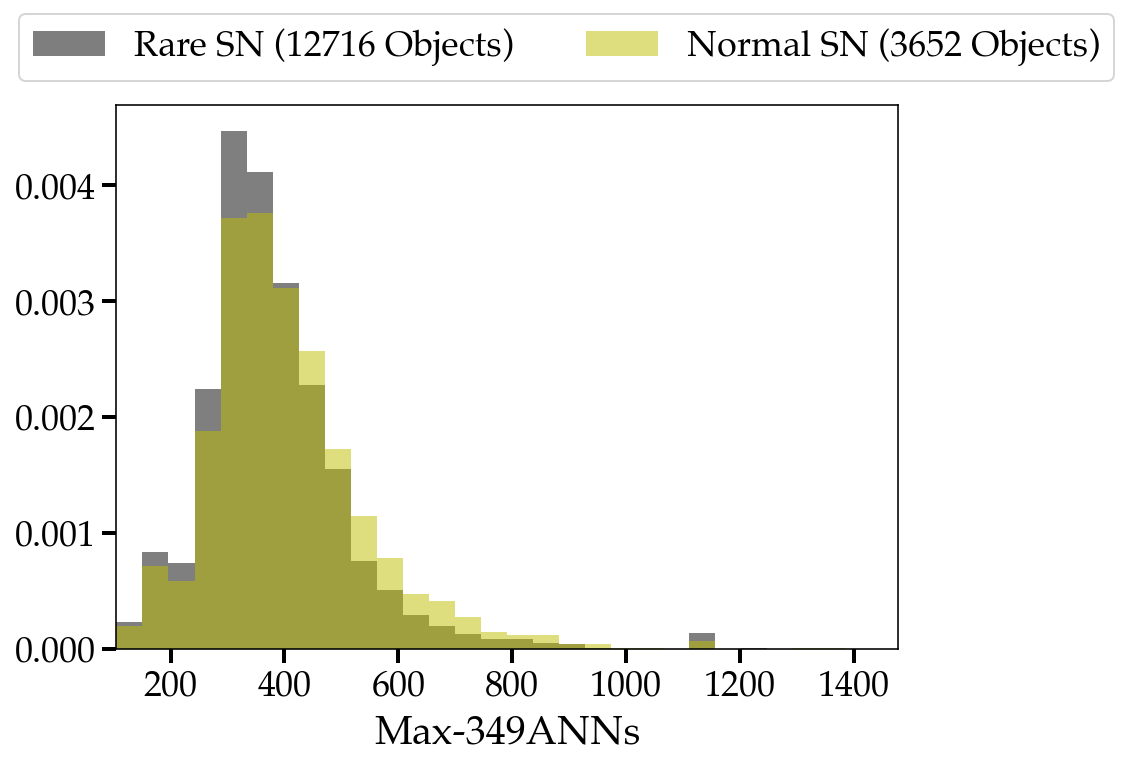

In [13]:
fig, ax = plt.subplots()
bins=np.linspace(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]), 31)
    

rare_sn_l = ['SLSN-I', 'SLSN-II', 'SN II-pec', 'SN IIb', 'SN IIn', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM',
   'SN Ia-pec', 'SN Iax[02cx-like]', 'SN Ib', 'SN Ib-pec', 'SN Ib/c',
   'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SN Icn', 'TDE']
rare_sn_df = merge_df[merge_df.tns_cls.isin(rare_sn_l)]
ax.hist(rare_sn_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN ({len(rare_sn_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_sn_l = ['SN', 'SN I', 'SN II', 'SN Ia']
normal_sn_df = merge_df[merge_df.tns_cls.isin(normal_sn_l)]
ax.hist(normal_sn_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN ({len(normal_sn_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]))
#plt.xscale('log')
plt.xlabel(dist_col)
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig(f'../figures/histograms/ann_dist_all_df_{suffix}_2cls_{dist_col}.png')
plt.show()

In [17]:
# SMOTE

from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test

# run 100 tests
i=0
p_value_l = []
while i<1000:
    rare_sn_subsample = np.random.choice(rare_sn_df[dist_col], size=len(normal_sn_df), replace=False)
    stat, p_value = ks_2samp(normal_sn_df[dist_col], rare_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

# NOT SMOTE

# from scipy.stats import ks_2samp

# # Perform the KS test
# # Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# # Or implement the Mann-Whitney U test

# # run 100 tests
# i=0
# p_value_l = []
# while i<1000:
#     normal_sn_subsample = np.random.choice(normal_sn_df[dist_col], size=len(rare_sn_df), replace=False)
#     stat, p_value = ks_2samp(rare_sn_df[dist_col], normal_sn_subsample)
#     i+=1
#     p_value_l.append(p_value)

# # Print the results
# p_value = np.mean(p_value_l)
# print(f"KS test statistic: {stat}")
# print(f"P-value: {p_value}")
# if p_value > 0.05:
#     print("The two distributions are likely the same.")
# else:
#     print("The two distributions are likely different.")

KS test statistic: 0.0832420591456736
P-value: 1.0607394903125427e-10
The two distributions are likely different.


In [33]:
np.median(normal_sn_df[dist_col])

472.6327209472656

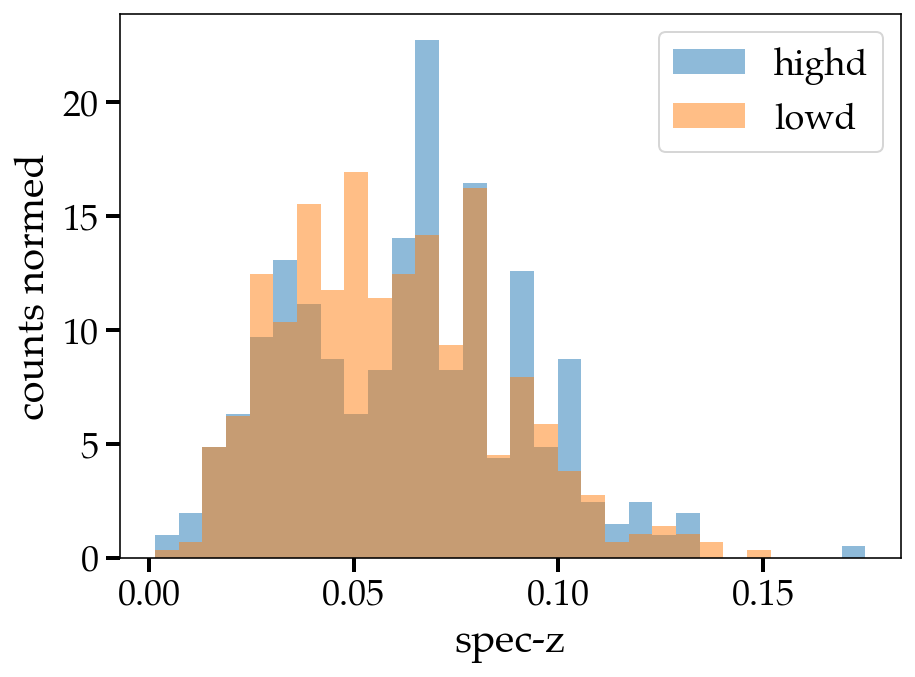

In [34]:
normal_sn_df = normal_sn_df[normal_sn_df.spec_z >= 0]

normal_sn_highd_df = normal_sn_df[normal_sn_df[dist_col] >= 500]
normal_sn_lowd_df = normal_sn_df[normal_sn_df[dist_col] <= 500]

bins=np.linspace(np.min(normal_sn_highd_df.spec_z), np.max(normal_sn_highd_df.spec_z), 31)
plt.hist(normal_sn_highd_df.spec_z, bins=bins, alpha=0.5, density=True, label='highd')
plt.hist(normal_sn_lowd_df.spec_z, bins=bins, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [36]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_sn_lowd_df.spec_z, size=len(normal_sn_highd_df), replace=False)
    stat, p_value = ks_2samp(normal_sn_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.10084033613445378
P-value: 0.02303472578557618
The two distributions are likely different.


In [37]:
np.median(rare_sn_df[dist_col])

359.3238830566406

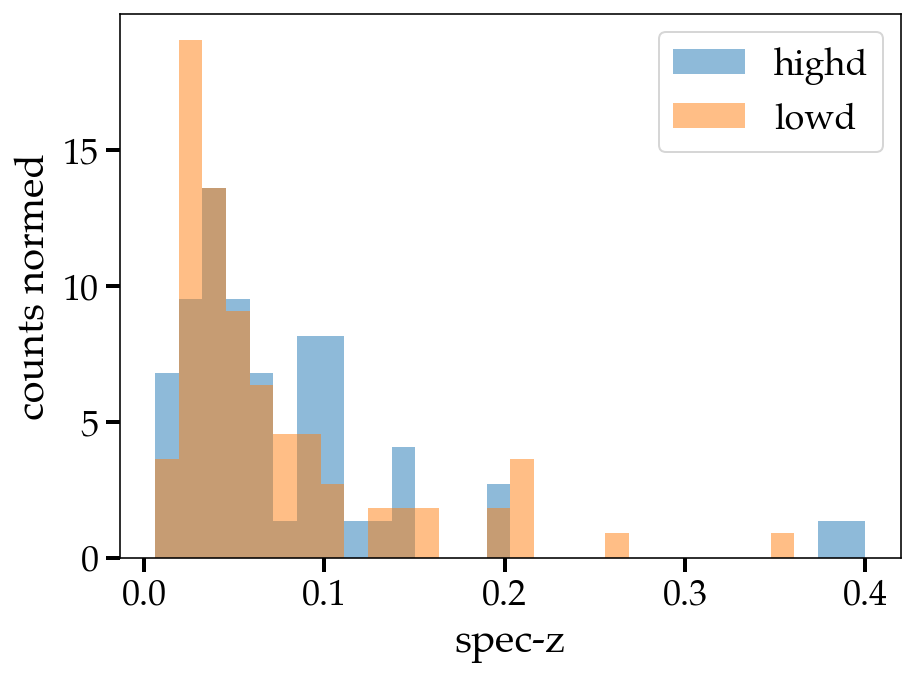

In [44]:
rare_sn_df = rare_sn_df[rare_sn_df.spec_z >= 0]

rare_sn_highd_df = rare_sn_df[rare_sn_df[dist_col] >= 450]
rare_sn_lowd_df = rare_sn_df[rare_sn_df[dist_col] <= 450]

bins=np.linspace(np.min(rare_sn_highd_df.spec_z), np.max(rare_sn_highd_df.spec_z), 31)
plt.hist(rare_sn_highd_df.spec_z, bins=bins, alpha=0.5, density=True, label='highd')
plt.hist(rare_sn_lowd_df.spec_z, bins=bins, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [45]:
len(rare_sn_lowd_df)

85

In [46]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(rare_sn_lowd_df.spec_z, size=len(rare_sn_highd_df), replace=False)
    stat, p_value = ks_2samp(rare_sn_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.16071428571428573
P-value: 0.6332621009116917
The two distributions are likely the same.


fig, ax = plt.subplots()
bins=np.linspace(25, 150, 31)
    

rare_sn_l = ['SLSN-I', 'SLSN-II', 'SN II-pec', 'SN IIb', 'SN IIn', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM',
   'SN Ia-pec', 'SN Iax[02cx-like]', 'SN Ib', 'SN Ib-pec', 'SN Ib/c',
   'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SN Icn', 'TDE']
rare_sn_df = merge_df[merge_df.tns_cls.isin(rare_sn_l)]
ax.hist(rare_sn_df["Mean-49ANNs"], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN ({len(rare_sn_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_sn_l = ['SN', 'SN I', 'SN II', 'SN Ia']
normal_sn_df = merge_df[merge_df.tns_cls.isin(normal_sn_l)]
ax.hist(normal_sn_df["Mean-49ANNs"], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN ({len(normal_sn_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(25, 150)
plt.xlabel('Mean-49ANNs')
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig('../figures/histograms/ann_dist_all_df_hasTNS_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_2cls_Mean.png')
plt.show()

from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_sn_df["Mean-49ANNs"], size=len(rare_sn_df), replace=False)
    stat, p_value = ks_2samp(rare_sn_df["Mean-49ANNs"], normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

## No statistical difference between Rare SN and Normal SN 

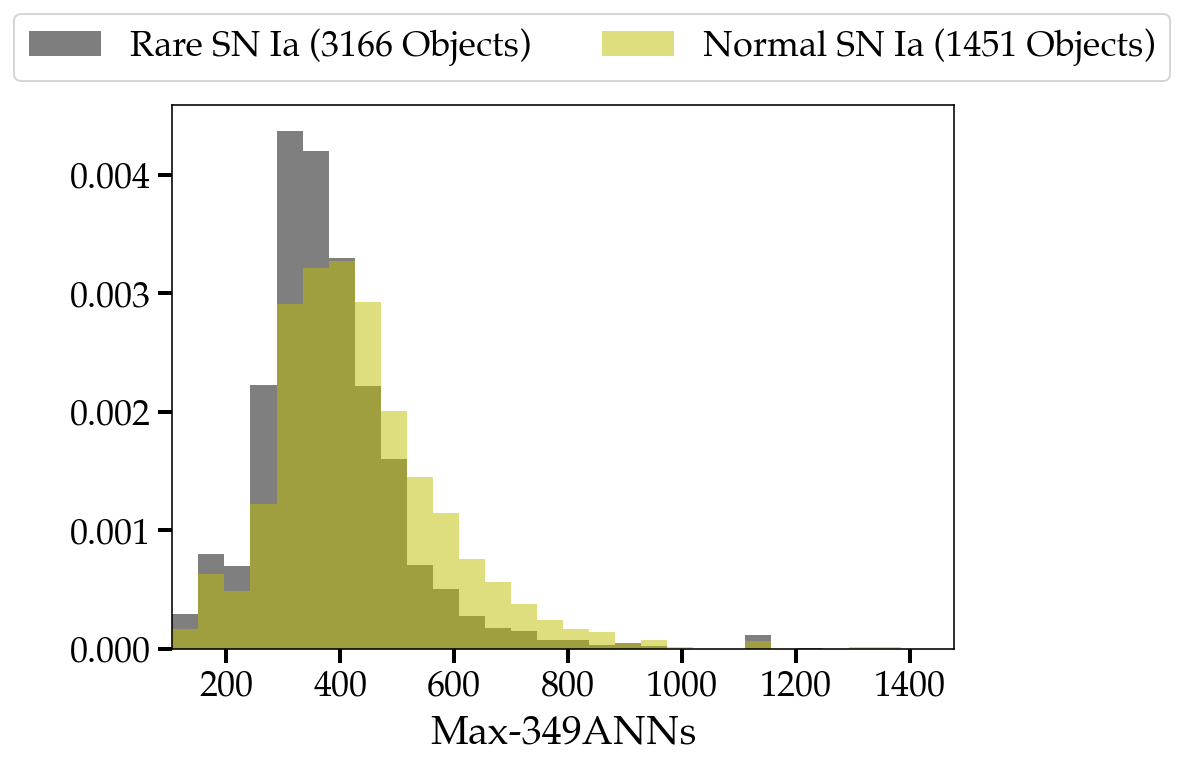

In [47]:
fig, ax = plt.subplots()
bins=np.linspace(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]), 31)
    

rare_snIa_l = ['SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM', 'SN Ia-pec', 'SN Iax[02cx-like]']
rare_snIa_df = merge_df[merge_df.tns_cls.isin(rare_snIa_l)]
ax.hist(rare_snIa_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN Ia ({len(rare_snIa_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_snIa_l = ['SN Ia']
normal_snIa_df = merge_df[merge_df.tns_cls.isin(normal_snIa_l)]
ax.hist(normal_snIa_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN Ia ({len(normal_snIa_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]))
plt.xlabel(dist_col)
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig(f'../figures/histograms/ann_dist_all_df_{suffix}_2cls_{dist_col}_Ia.png')
plt.show()

In [49]:
# Yes SMOTE

from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    rare_snIa_subsample = np.random.choice(rare_snIa_df[dist_col], size=len(normal_snIa_df), replace=False)
    stat, p_value = ks_2samp(normal_snIa_df[dist_col], rare_snIa_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")


# No SMOTE

# from scipy.stats import ks_2samp

# # Perform the KS test
# # Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# # Or implement the Mann-Whitney U test
# # run 100 tests
# i=0
# p_value_l = []
# while i<1000:
#     normal_snIa_subsample = np.random.choice(normal_snIa_df[dist_col], size=len(rare_snIa_df), replace=False)
#     stat, p_value = ks_2samp(rare_snIa_df[dist_col], normal_snIa_subsample)
#     i+=1
#     p_value_l.append(p_value)

# # Print the results
# p_value = np.mean(p_value_l)
# print(f"KS test statistic: {stat}")
# print(f"P-value: {p_value}")
# if p_value > 0.05:
#     print("The two distributions are likely the same.")
# else:
#     print("The two distributions are likely different.")

KS test statistic: 0.20537560303239144
P-value: 5.093145690723233e-19
The two distributions are likely different.


## No statistical difference between Rare SN Ia and Normal SN Ia...

In [50]:
np.median(normal_snIa_df[dist_col])

412.33935546875

In [51]:
normal_snIa_highd_df = normal_snIa_df[normal_snIa_df[dist_col] >= 450]
normal_snIa_lowd_df = normal_snIa_df[normal_snIa_df[dist_col] <= 450]

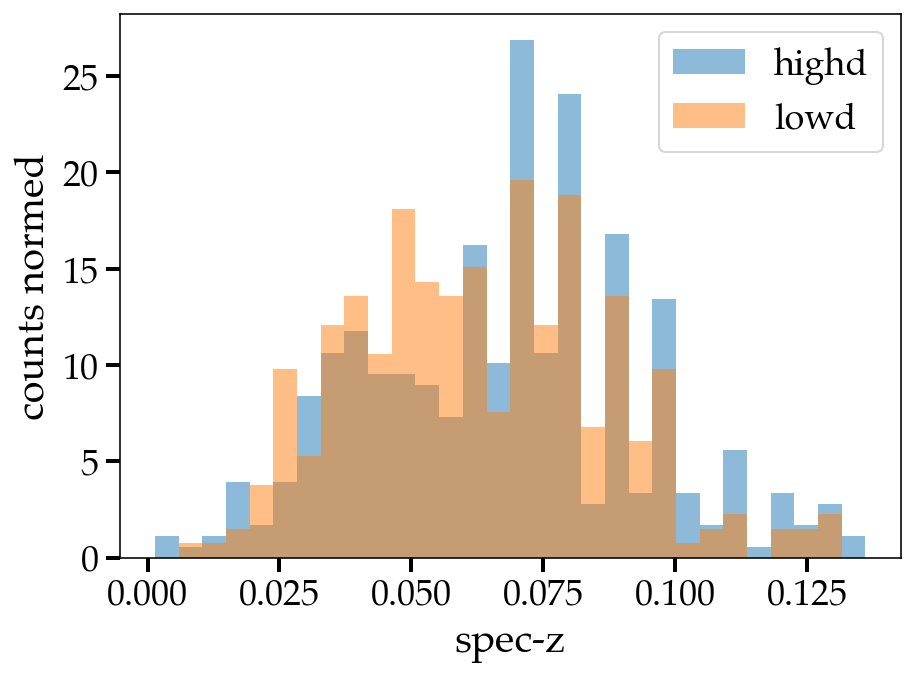

In [53]:
normal_snIa_highd_df = normal_snIa_highd_df[normal_snIa_highd_df.spec_z >= 0]

bins=np.linspace(np.min(normal_snIa_highd_df.spec_z), np.max(normal_snIa_highd_df.spec_z), 31)
plt.hist(normal_snIa_highd_df.spec_z, bins=bins, alpha=0.5, density=True, label='highd')
plt.hist(normal_snIa_lowd_df.spec_z, bins=bins, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [54]:
normal_snIa_highd_df.spec_z

ztf_object_id
ZTF18aahfbqp    0.041362
ZTF18aaisqmw    0.052700
ZTF18aaizgoq    0.070000
ZTF18aajjhkq    0.070000
ZTF18aansqov    0.070000
                  ...   
ZTF21acdnnfg    0.068000
ZTF21acefkpy    0.055327
ZTF21acenkuf    0.012319
ZTF21ackbbfs    0.045000
ZTF21acldmwy    0.110000
Name: spec_z, Length: 398, dtype: float64

In [55]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_snIa_lowd_df.spec_z, size=len(normal_snIa_highd_df), replace=False)
    stat, p_value = ks_2samp(normal_snIa_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.6557788944723618
P-value: 6.944269787872775e-72
The two distributions are likely different.


In [56]:
np.median(rare_snIa_df[dist_col])

361.4712524414063

In [57]:

rare_snIa_highd_df = rare_snIa_df[rare_snIa_df[dist_col] >= 380]
rare_snIa_lowd_df = rare_snIa_df[rare_snIa_df[dist_col] <= 380]

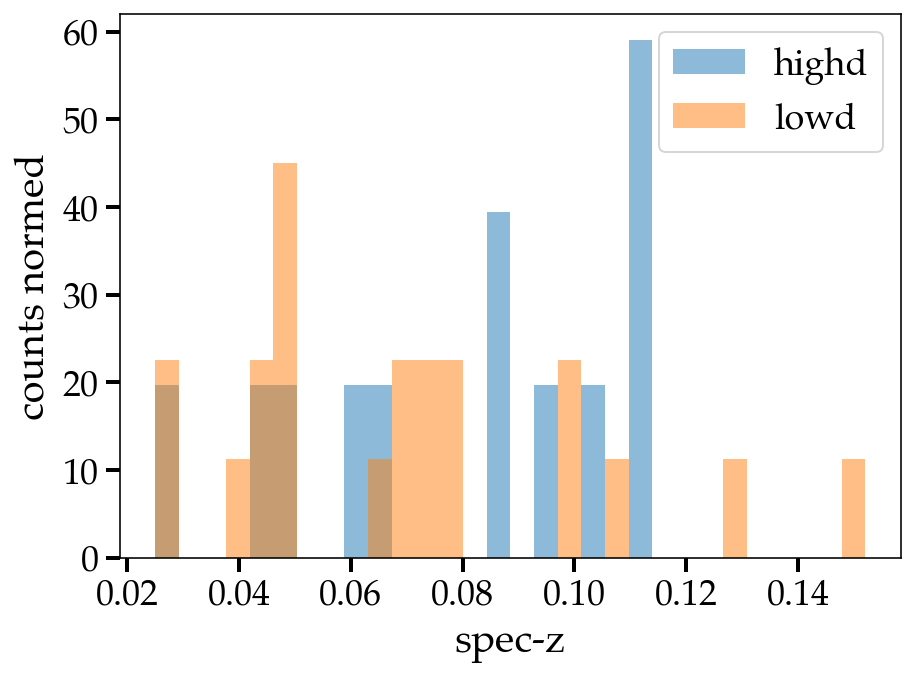

In [65]:
rare_snIa_df = rare_snIa_df[rare_snIa_df.spec_z>=0]

rare_snIa_highd_df = rare_snIa_df[rare_snIa_df[dist_col] >= 450]
rare_snIa_lowd_df = rare_snIa_df[rare_snIa_df[dist_col] <= 450]

bins=np.linspace(np.min(rare_snIa_df.spec_z), np.max(rare_snIa_df.spec_z), 31)

plt.hist(rare_snIa_highd_df.spec_z, bins=bins, alpha=0.5, density=True, label='highd')
plt.hist(rare_snIa_lowd_df.spec_z, bins=bins, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [66]:
len(rare_snIa_highd_df)

12

In [67]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(rare_snIa_lowd_df.spec_z, size=len(rare_snIa_highd_df), replace=False)
    stat, p_value = ks_2samp(rare_snIa_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.3333333333333333
P-value: 0.5087390927150652
The two distributions are likely the same.


# Objs w/ high distances ANNs are Bright/closeby (generally...)
# TODO: how to define "rare"? --> Closeby & bright or rare phenomenology or ???
# Maybe "normalize out" brightness to focus on truly rare SN classes/types/ LCs?

# UPDATED: brightness CAN be normalized out (w/ l1 norm and MI_classif), but tradeoff between good similarity (and host galaxy). If host gal weights all = 0.008 (1/120), then sim is good but high d and low d correspond to low z and high z, respectively. However, if I don't overweight hosts, sim search is not as good but high d and low d DO NOT correspond to low z and high z. So high d and low d objects are not dependent on redshift! But still no diff between rare SN and normal SN ... :( ?

# L1 norm & MI_classif (+changes) normalizes brightness ANN d but not great at AD, but Standard Scaler & MI_classif (+changes) is good at Sim Search, but not great at AD. What is great at AD if features overlap??? Try other scalers?

In [68]:
# rare b/c closeby and bright or dust extincted or lc on decline

for snia in normal_snIa_highd_df.index:
    print(f'https://alerce.online/object/{snia}')

https://alerce.online/object/ZTF18aahfbqp
https://alerce.online/object/ZTF18aaisqmw
https://alerce.online/object/ZTF18aaizgoq
https://alerce.online/object/ZTF18aajjhkq
https://alerce.online/object/ZTF18aansqov
https://alerce.online/object/ZTF18aaoxrup
https://alerce.online/object/ZTF18aayyqia
https://alerce.online/object/ZTF18abrbywo
https://alerce.online/object/ZTF18abrfccm
https://alerce.online/object/ZTF18acaucsw
https://alerce.online/object/ZTF18acbuibx
https://alerce.online/object/ZTF18acbvgtu
https://alerce.online/object/ZTF18acbygcu
https://alerce.online/object/ZTF18acbyyff
https://alerce.online/object/ZTF18accrorf
https://alerce.online/object/ZTF18acptgzz
https://alerce.online/object/ZTF18acsohut
https://alerce.online/object/ZTF18acsovsw
https://alerce.online/object/ZTF18acsremz
https://alerce.online/object/ZTF18actuhrs
https://alerce.online/object/ZTF20aatxryt
https://alerce.online/object/ZTF20abeywdn
https://alerce.online/object/ZTF20abptxls
https://alerce.online/object/ZTF20

In [69]:
rare_snIa_df[rare_snIa_df[dist_col] >= 200]

,Mean-349ANNs,Max-349ANNs,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF18aarindm,286.462664,392.533508,0.428956,-0.307087,0.294118,0.242536,0.279155,0.857912,0.448406,0.330381,...,0.157301,0.185900,0.118599,0.131100,20.202333,0.062095,Yes_TNS,SN Ia-91T-like,0.097000,ATLAS
ZTF20acbttnt,362.111387,443.929749,0.881788,0.072522,0.259259,0.333333,0.390567,1.757213,1.471910,0.613793,...,0.044298,0.024801,-0.036400,-0.012701,26.066905,0.059987,Yes_TNS,SN Ia-91T-like,0.099000,ZTF
ZTF20acgkuay,387.270560,568.937683,0.650919,-0.292569,0.250000,0.000000,0.420268,1.301838,1.228517,0.905101,...,-0.025000,-0.010500,-0.079100,-0.130199,74.627802,1.422817,Yes_TNS,SN Ia-91bg-like,0.048460,SGLF
ZTF20achrklb,295.007898,396.118011,0.581516,-0.251411,0.285714,0.000000,0.421545,1.163033,1.059608,0.763575,...,0.847501,1.119401,1.340700,1.147201,153.658414,0.096082,Yes_TNS,SN Ia-91T-like,0.070000,ALeRCE
ZTF20achuvhd,264.805710,330.411102,0.308250,-0.448704,0.500000,0.000000,0.385743,0.616501,0.585591,0.349963,...,1.007199,0.767300,1.152499,0.953200,305.731599,0.673794,Yes_TNS,SN Ia-91T-like,0.076000,ALeRCE
ZTF20acjdhof,282.317919,383.288544,0.200150,-0.507602,0.285714,0.000000,0.413319,0.400301,0.370345,0.238144,...,0.154699,0.237598,0.226000,0.148300,1.687467,0.111790,Yes_TNS,SN Ia-91T-like,0.152000,ALeRCE
ZTF20acpwjus,346.426166,447.007690,0.986750,-0.148379,0.421053,0.000000,0.441164,1.973499,1.577398,1.092402,...,0.733299,0.696800,0.940400,0.776899,72.294959,0.115965,Yes_TNS,SN Ia-91T-like,0.075000,ALeRCE
ZTF20acvbrbv,97.356326,211.989273,0.276750,-0.707905,0.285714,0.000000,0.368579,0.553499,0.502217,0.248578,...,1.466599,1.611800,1.404900,1.315499,140.312110,0.157087,Yes_TNS,SN Ia-91bg-like,0.050000,ZTF
ZTF20acvbvyb,722.952264,843.641052,0.581827,-0.034231,0.300000,0.000000,0.373181,1.163654,1.071925,0.327139,...,0.518700,0.559700,0.642900,0.702200,9.525393,0.759920,Yes_TNS,SN Ia-91T-like,0.111000,YSE


## TODO: find a new method for really Rare SN!
## TODO: Also, find if Rare SN--> Rare SN and Normal SN --> Normal SN

In [70]:
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after"
#suffix="hasTNS-spec_NOpca_noCadence_NOtransf_HasHostGalOnly_SS"
#suffix="hasTNS_NOpca_noCadence_NOtransf_HasHostGalOnly_SS"

full_ann_properties_df = pd.read_csv(f'../dataframes/full_ann_properties_df_{suffix}.csv', index_col=0)
full_ann_properties_df

,ann=0_ztfid,ann=1_ztfid,ann=2_ztfid,ann=3_ztfid,ann=4_ztfid,ann=5_ztfid,ann=6_ztfid,ann=7_ztfid,ann=8_ztfid,ann=9_ztfid,...,ann=0_spec_z,ann=1_spec_z,ann=2_spec_z,ann=3_spec_z,ann=4_spec_z,ann=5_spec_z,ann=6_spec_z,ann=7_spec_z,ann=8_spec_z,ann=9_spec_z
0,ZTF17aaahrni,ZTFabc90396,ZTFabc51811,ZTFabc27667,ZTFabc80295,ZTFabc01141,ZTFabc73276,ZTF21abctgsv,ZTFabc22548,ZTFabc97077,...,-99.000,-99.0,-99.0000,-99.0,-99.0,-99.000,-99.0,-99.000000,-99.0,-99.0
1,ZTF17aadqidc,ZTF21acimaio,ZTF21aarigez,ZTFabc37872,ZTFabc72775,ZTF21abbewsz,ZTFabc41013,ZTF20abkqmeq,ZTFabc92619,ZTFabc70649,...,-99.000,-99.0,-99.0000,-99.0,-99.0,0.075,-99.0,-99.000000,-99.0,-99.0
2,ZTF18aabdnbr,ZTFabc16011,ZTFabc10809,ZTFabc90394,ZTFabc73520,ZTFabc14608,ZTFabc71784,ZTFabc25327,ZTFabc83241,ZTFabc00154,...,-99.000,-99.0,-99.0000,-99.0,-99.0,-99.000,-99.0,-99.000000,-99.0,-99.0
3,ZTF18aabeszt,ZTFabc70056,ZTFabc63173,ZTF20acqtaiq,ZTFabc89007,ZTF19aaajcbb,ZTFabc34292,ZTFabc95366,ZTFabc86149,ZTFabc77022,...,0.081,-99.0,-99.0000,-99.0,-99.0,-99.000,-99.0,-99.000000,-99.0,-99.0
4,ZTF18aabvmws,ZTF18aakeanj,ZTF21abgxudc,ZTF21aaaollj,ZTFabc14786,ZTFabc25313,ZTFabc17942,ZTF21aagmryd,ZTFabc70617,ZTFabc15706,...,-99.000,-99.0,0.0264,-99.0,-99.0,-99.000,-99.0,0.027489,-99.0,-99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,ZTFabc84829,ZTFabc42365,ZTFabc14083,ZTFabc29083,ZTFabc17822,ZTFabc05095,ZTFabc96792,ZTFabc39486,ZTFabc33754,ZTFabc39630,...,-99.000,-99.0,-99.0000,-99.0,-99.0,-99.000,-99.0,-99.000000,-99.0,-99.0
4996,ZTFabc11616,ZTFabc15643,ZTFabc94801,ZTFabc24155,ZTFabc35154,ZTFabc43637,ZTFabc25148,ZTFabc92696,ZTFabc58898,ZTFabc78213,...,-99.000,-99.0,-99.0000,-99.0,-99.0,-99.000,-99.0,-99.000000,-99.0,-99.0
4997,ZTFabc26245,ZTFabc72199,ZTFabc93989,ZTFabc44131,ZTFabc79033,ZTFabc68237,ZTFabc91086,ZTFabc92964,ZTFabc22723,ZTFabc09671,...,-99.000,-99.0,-99.0000,-99.0,-99.0,-99.000,-99.0,-99.000000,-99.0,-99.0
4998,ZTFabc98501,ZTFabc53663,ZTFabc67695,ZTFabc72146,ZTFabc83224,ZTFabc90802,ZTFabc10219,ZTFabc49237,ZTFabc78139,ZTFabc52067,...,-99.000,-99.0,-99.0000,-99.0,-99.0,-99.000,-99.0,-99.000000,-99.0,-99.0


In [71]:
full_ann_tns_cls_df = full_ann_properties_df.iloc[:, 30:40]
full_ann_tns_cls_df

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls
0,None,SN II,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,None,SLSN-I,SLSN-I
1,None,None,None,SN Ia,SN Ia,SN Ia,SN Ia,None,SN Ibn,SN Ibn
2,None,SN II,SN II,SN II,SN II,SN II,SN II,SN II,SN II,SN II
3,SN Ia,SN Ia,SN Ia,None,SN Ia,None,SN Ic,SN Ic,SN Ic,SN Ic
4,None,None,SN Ia,None,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia
...,...,...,...,...,...,...,...,...,...,...
4995,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I
4996,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I
4997,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I
4998,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I


In [72]:
full_ann_spec_z_df = full_ann_properties_df.iloc[:, 40:50]
full_ann_spec_z_df

,ann=0_spec_z,ann=1_spec_z,ann=2_spec_z,ann=3_spec_z,ann=4_spec_z,ann=5_spec_z,ann=6_spec_z,ann=7_spec_z,ann=8_spec_z,ann=9_spec_z
0,-99.000,-99.0,-99.0000,-99.0,-99.0,-99.000,-99.0,-99.000000,-99.0,-99.0
1,-99.000,-99.0,-99.0000,-99.0,-99.0,0.075,-99.0,-99.000000,-99.0,-99.0
2,-99.000,-99.0,-99.0000,-99.0,-99.0,-99.000,-99.0,-99.000000,-99.0,-99.0
3,0.081,-99.0,-99.0000,-99.0,-99.0,-99.000,-99.0,-99.000000,-99.0,-99.0
4,-99.000,-99.0,0.0264,-99.0,-99.0,-99.000,-99.0,0.027489,-99.0,-99.0
...,...,...,...,...,...,...,...,...,...,...
4995,-99.000,-99.0,-99.0000,-99.0,-99.0,-99.000,-99.0,-99.000000,-99.0,-99.0
4996,-99.000,-99.0,-99.0000,-99.0,-99.0,-99.000,-99.0,-99.000000,-99.0,-99.0
4997,-99.000,-99.0,-99.0000,-99.0,-99.0,-99.000,-99.0,-99.000000,-99.0,-99.0
4998,-99.000,-99.0,-99.0000,-99.0,-99.0,-99.000,-99.0,-99.000000,-99.0,-99.0


In [73]:
# Create Graph df
graph_df = pd.DataFrame()
graph_df['node'] = full_ann_tns_cls_df["ann=0_tns_cls"]

ann_tns_cls_col_list= [f'ann={col}_tns_cls' for col in range(1, 10)]
graph_df['neighbors'] = full_ann_tns_cls_df[ann_tns_cls_col_list].apply(list, axis=1)
graph_df

,node,neighbors
0,None,"[SN II, SLSN-I, SLSN-I, SLSN-I, SLSN-I, SLSN-I..."
1,None,"[None, None, SN Ia, SN Ia, SN Ia, SN Ia, None,..."
2,None,"[SN II, SN II, SN II, SN II, SN II, SN II, SN ..."
3,SN Ia,"[SN Ia, SN Ia, None, SN Ia, None, SN Ic, SN Ic..."
4,None,"[None, SN Ia, None, SN Ia, SN Ia, SN Ia, SN Ia..."
...,...,...
4995,SLSN-I,"[SLSN-I, SLSN-I, SLSN-I, SLSN-I, SLSN-I, SLSN-..."
4996,SLSN-I,"[SLSN-I, SLSN-I, SLSN-I, SLSN-I, SLSN-I, SLSN-..."
4997,SLSN-I,"[SLSN-I, SLSN-I, SLSN-I, SLSN-I, SLSN-I, SLSN-..."
4998,SLSN-I,"[SLSN-I, SLSN-I, SLSN-I, SLSN-I, SLSN-I, SLSN-..."


In [81]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ibn']

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls
1842,SN Ibn,SN Ibn,SN Ibn,SN Ibn,SN Ibn,SN Ibn,SN Ibn,SN Ibn,SN Ibn,SN Ibn
2048,SN Ibn,SN Ibn,SN Ibn,SN Ibn,SN Ibn,SN Ibn,SN Ibn,SN Ibn,SN Ibn,SN Ibn
2199,SN Ibn,SN Ibn,SN Ibn,SN Ibn,SN Ibn,SN Ibn,SN Ibn,SN Ibn,SN Ibn,SN Ibn
2624,SN Ibn,SN Ibn,SN Ibn,SN Ibn,SN Ibn,SN Ibn,SN Ibn,SN Ibn,SN Ibn,SN Ibn


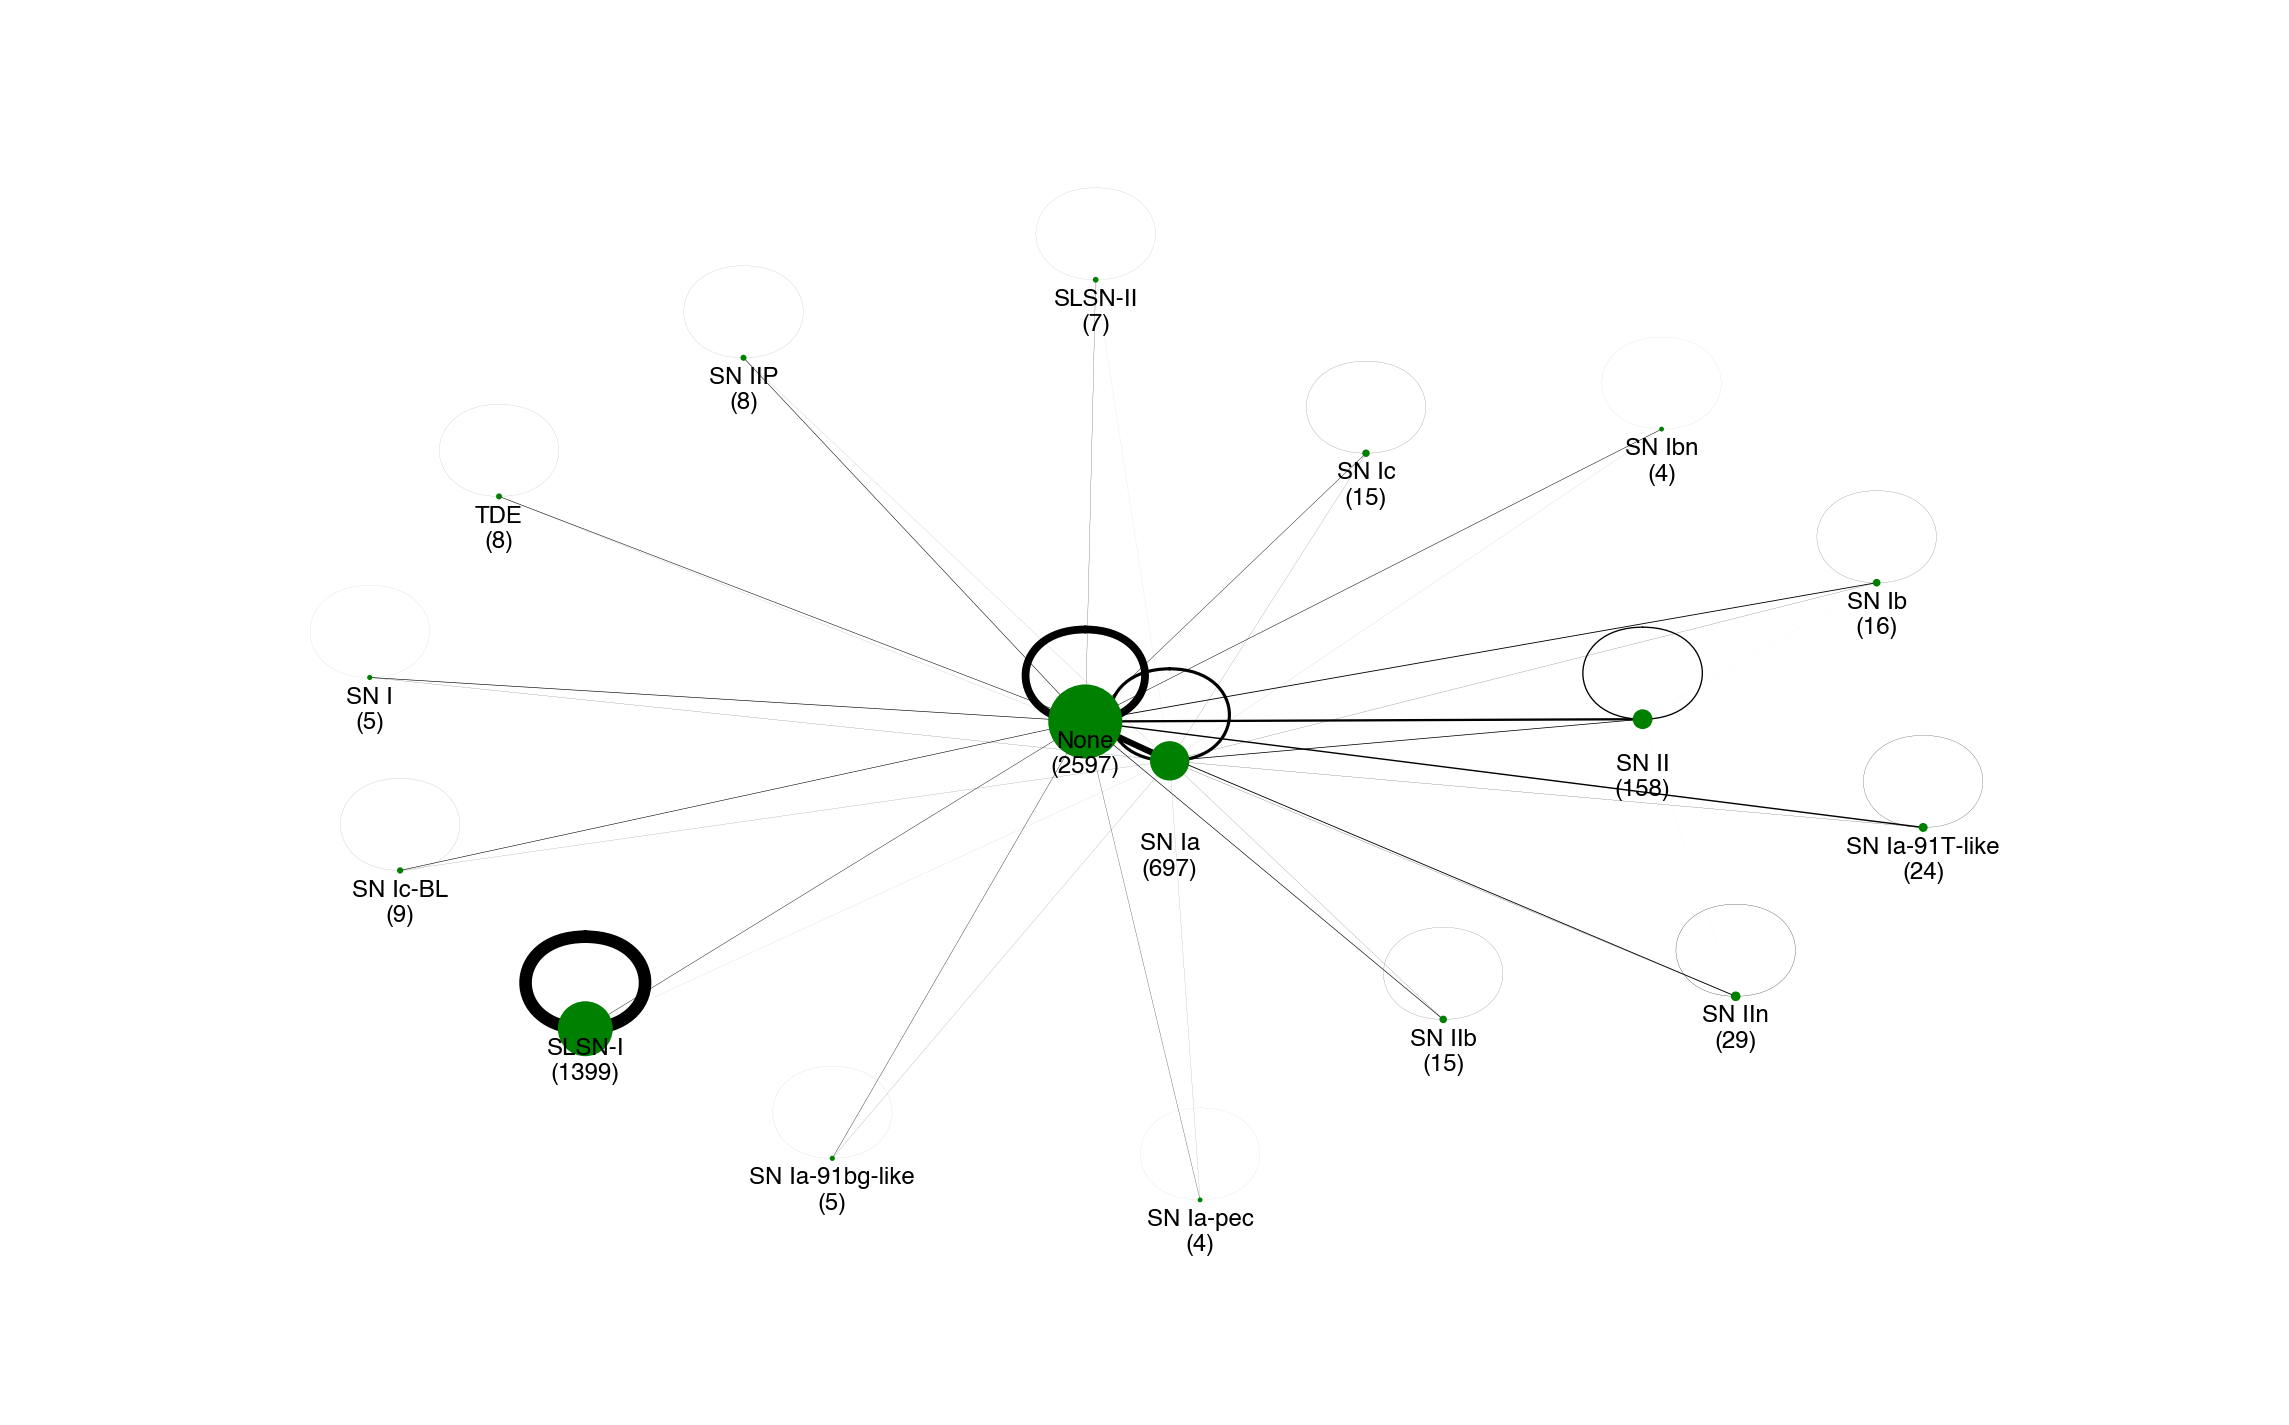

In [75]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


# Create a sample dataframe with node and edge data
df = graph_df.copy()
# Create a list of edges
edges = [(row['node'], to) for _, row in df.iterrows() for to in row['neighbors']]

# Create a network graph from the edges
G = nx.Graph()
G.add_edges_from(edges)

# Compute the frequency of each unique connection
edge_freq = {}
for u, v in edges:
    key = (min(u, v), max(u, v))
    edge_freq[key] = edge_freq.get(key, 0) + 1
    
# Add edge labels with frequency
edge_labels = {}
for u, v, d in G.edges(data=True):
    key = (min(u, v), max(u, v))
    #if edge_freq[key] >= 500:
    edge_labels[(u, v)] = str(edge_freq[key])
    
# set edge widths based on frequency
edge_widths = [int(edge_labels[edge])/2000 for edge in edge_labels]

node_count = dict(Counter(graph_df['node']))

# Scale the node sizes by the occurrences of the node
#node_sizes = [1.2 * sum(1 for x in edges if x[0] == node or x[1] == node) for node in G.nodes()]
        
node_sizes = [node_count[node] * 0.5 for node in G.nodes()]
#print(node_sizes)

# Plot the graph
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(16, 10))
nx.draw_networkx_nodes(G, pos, node_color='g', node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color='k', width=edge_widths)

# Move the labels of the nodes down right below the node
pos_labels = {}
for key, value in pos.items():
    pos_labels[key] = (value[0], value[1] - 0.07)
    
# count the number of times of each node 
node_count = dict(Counter(df['node']))

# scale node sizes by frequency
#node_sizes = [node_count[node] * 9 for node in G.nodes()]

# create labels with node and count information
node_labels_d1 = {node: f"{node}\n({node_count[node]})" for node in G.nodes() if node!='SN Ia' and node!='SN II'}
node_labels_d2 = {node: f"\n\n{node}\n({node_count[node]})" for node in G.nodes() if node=='SN II'}
node_labels = {node: f"\n\n\n\n\n{node}\n({node_count[node]})" for node in G.nodes() if node=='SN Ia'}

node_labels_d2.update(node_labels_d1)
node_labels.update(node_labels_d2)

nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=12, font_color='black')

#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12, font_color='black', font_weight='bold')

plt.axis('off')
axis = plt.gca()
axis.set_xlim([1.2*x for x in axis.get_xlim()])
axis.set_ylim([1.2*y for y in axis.get_ylim()])
plt.tight_layout()
plt.savefig(f'../figures/graphs/{suffix}_size_scaled.jpg', dpi=300)
plt.show()


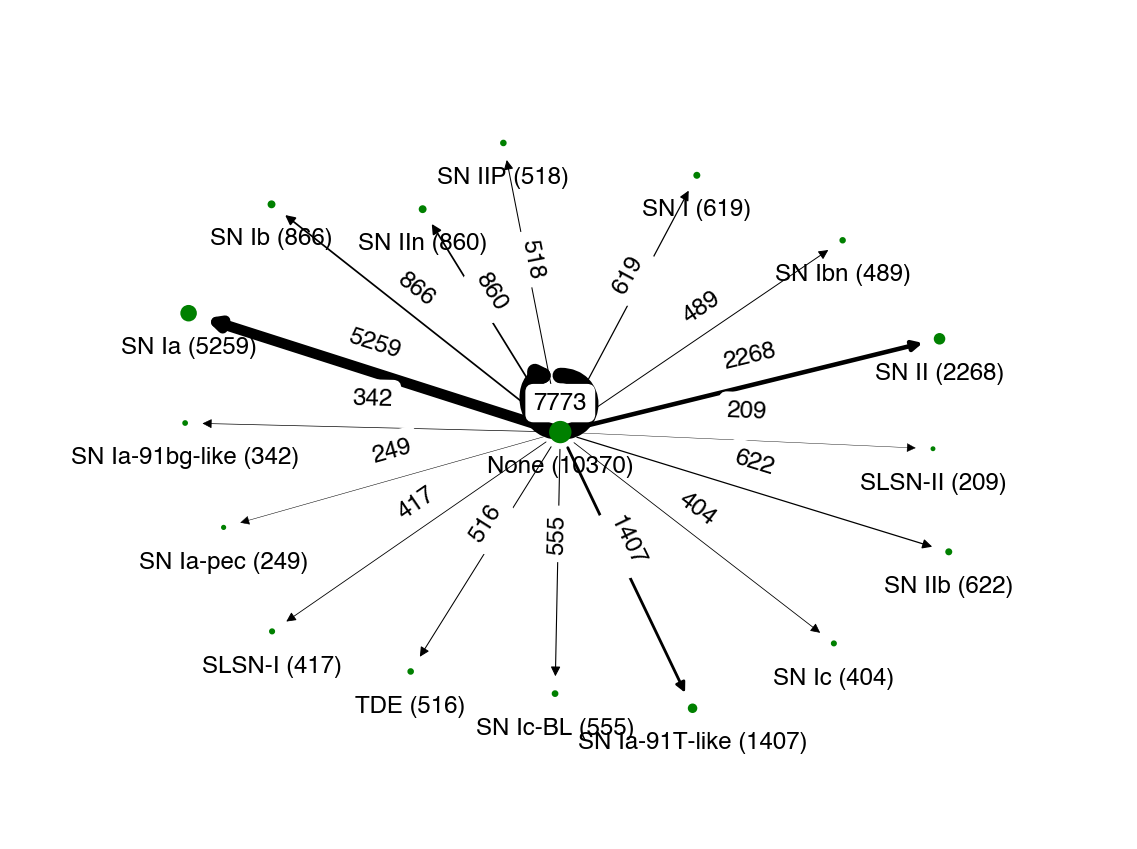

In [76]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

cls = 'None'
graph_df_cls = graph_df[graph_df.node == cls]


# Create a sample dataframe with node and edge data
df = graph_df_cls
# Create a list of edges
edges = [(row['node'], to) for _, row in df.iterrows() for to in row['neighbors']]

# Create a network graph from the edges
G = nx.DiGraph()
G.add_edges_from(edges)

# Compute the frequency of each unique connection
edge_freq = {}
for u, v in edges:
    key = (min(u, v), max(u, v))
    edge_freq[key] = edge_freq.get(key, 0) + 1
    
# Add edge labels with frequency
edge_labels = {}
for u, v, d in G.edges(data=True):
    key = (min(u, v), max(u, v))
    #if edge_freq[key] >= 500:
    edge_labels[(u, v)] = str(edge_freq[key])
    
# set edge widths based on frequency
edge_widths = [int(edge_labels[edge])/1000 for edge in edge_labels]

# Scale the node sizes by the occurrences of the node
#node_sizes = [10 * sum(1 for x in edges if x[0] == node or x[1] == node) for node in G.nodes()]
#print(node_sizes)

# explode the lists in the second column into separate rows
df = graph_df_cls
df_expl = df.explode('neighbors')

# group the data frame by the label column and count the number of unique values for each group
unique_node_d = dict(Counter(df['node']))
unique_neighbors_d = dict(Counter(df_expl['neighbors']))

for key in unique_neighbors_d:
    if key in unique_node_d:
        unique_node_d[key] += unique_neighbors_d[key]
    else:
        unique_node_d[key] = unique_neighbors_d[key]
        
node_count = unique_node_d
node_sizes = [node_count[node] * 0.01 for node in G.nodes()]
#print(node_sizes)

# Plot the graph
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos, node_color='g', node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color='k', width=edge_widths)

# Move the labels of the nodes down right below the node
pos_labels = {}
for key, value in pos.items():
    pos_labels[key] = (value[0], value[1] +.1)
    
    
# # count the number of times of each node 
# node_count = dict(Counter(graph_df_cv['node']))

# # scale node sizes by frequency
# node_sizes = [node_count[node] * 9 for node in G.nodes()]

# create labels with node and count information
node_labels = {node: f"\n\n\n\n\n{node} ({node_count[node]})" for node in G.nodes()}

nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=12, font_color='black')

nx.draw_networkx_edge_labels(G, pos_labels, edge_labels=edge_labels, font_size=12, font_color='black', font_weight='bold')


plt.axis('off')
axis = plt.gca()
axis.set_xlim([1.2*x for x in axis.get_xlim()])
axis.set_ylim([1.2*y for y in axis.get_ylim()])
plt.tight_layout()
#plt.savefig(f'../figures/graphs/{suffix}_size_scaled_None.jpg', dpi=300)
plt.show()


None


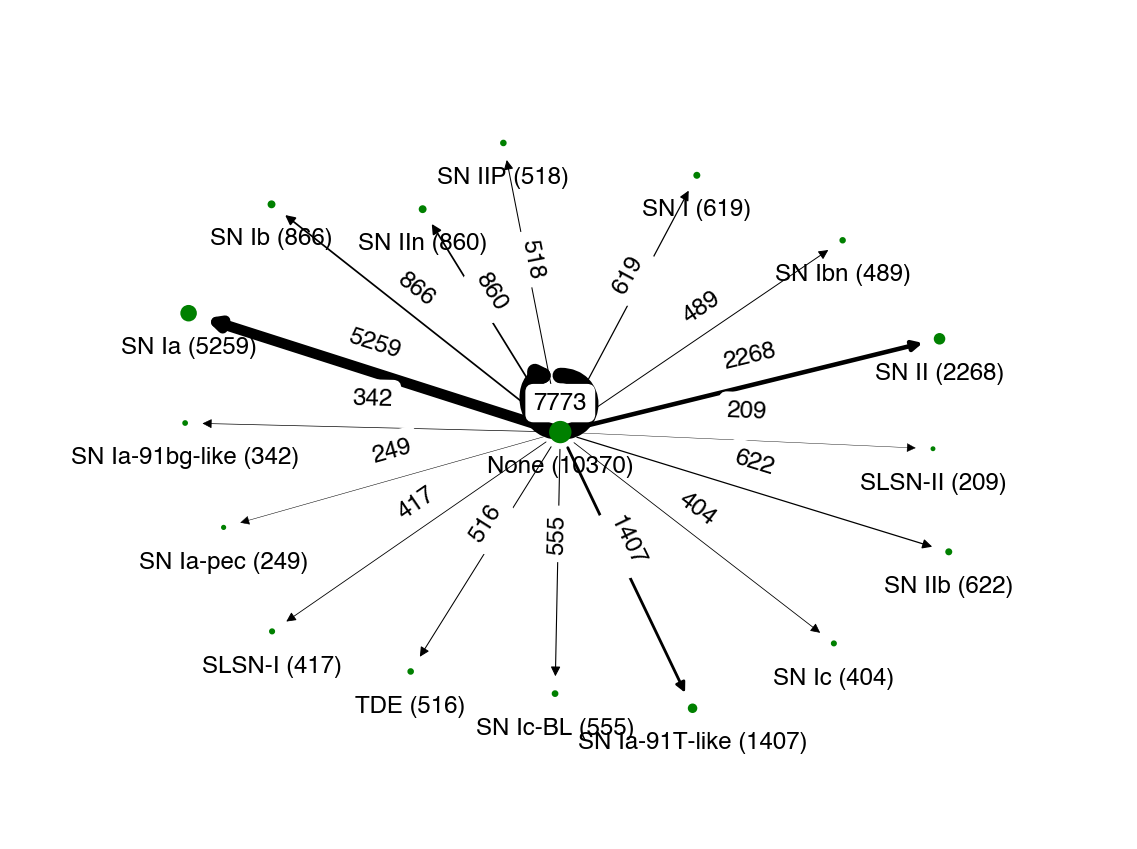

SLSN-I


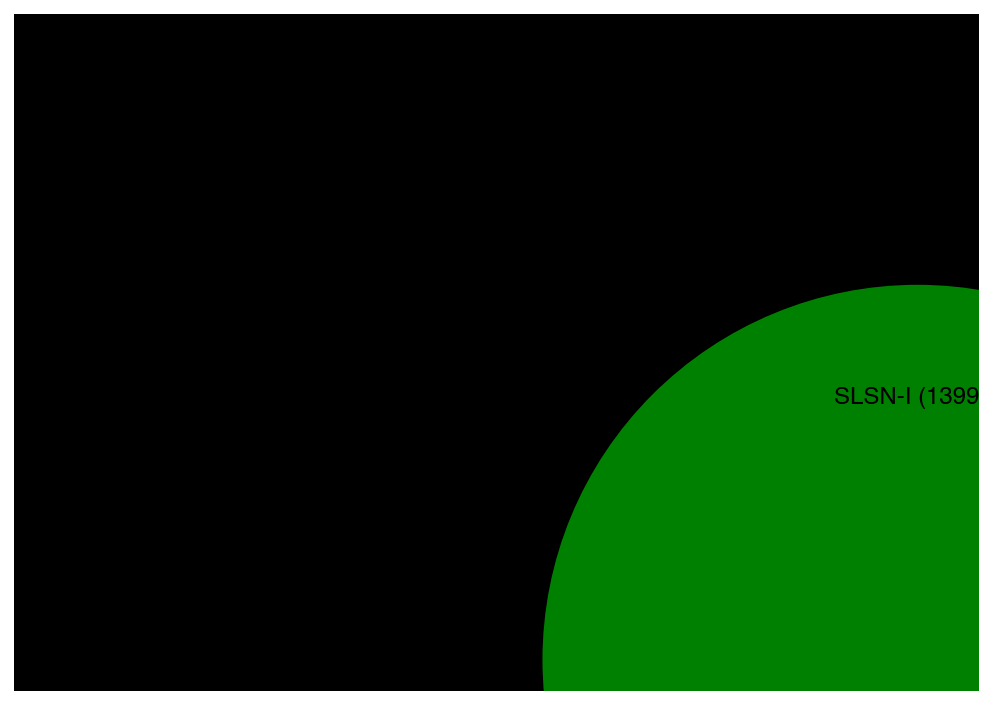

SLSN-II


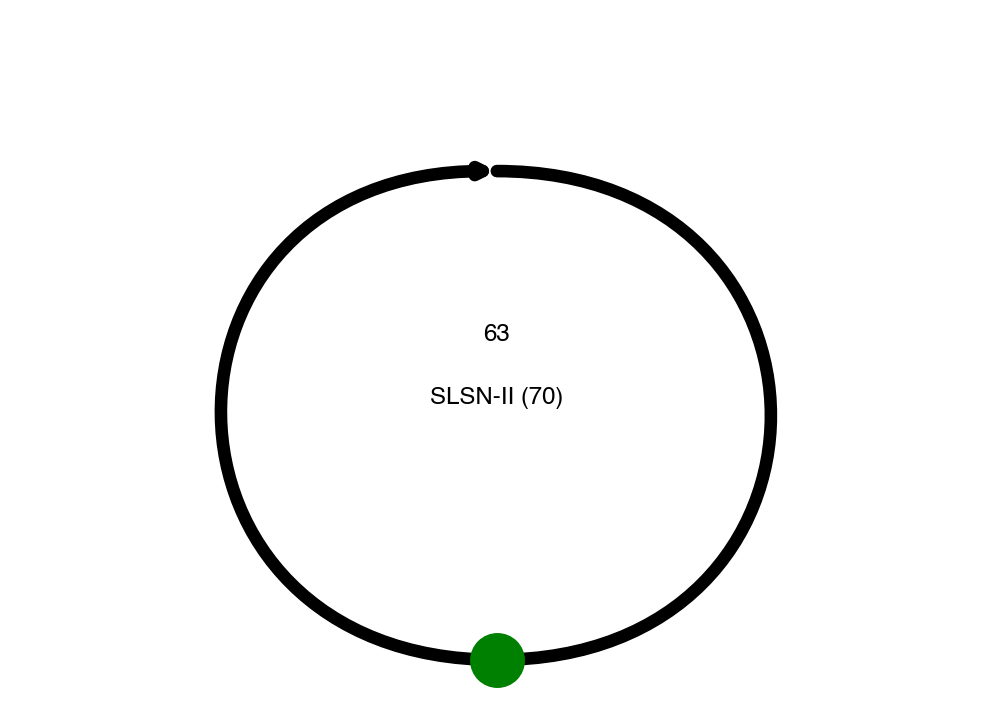

SN I


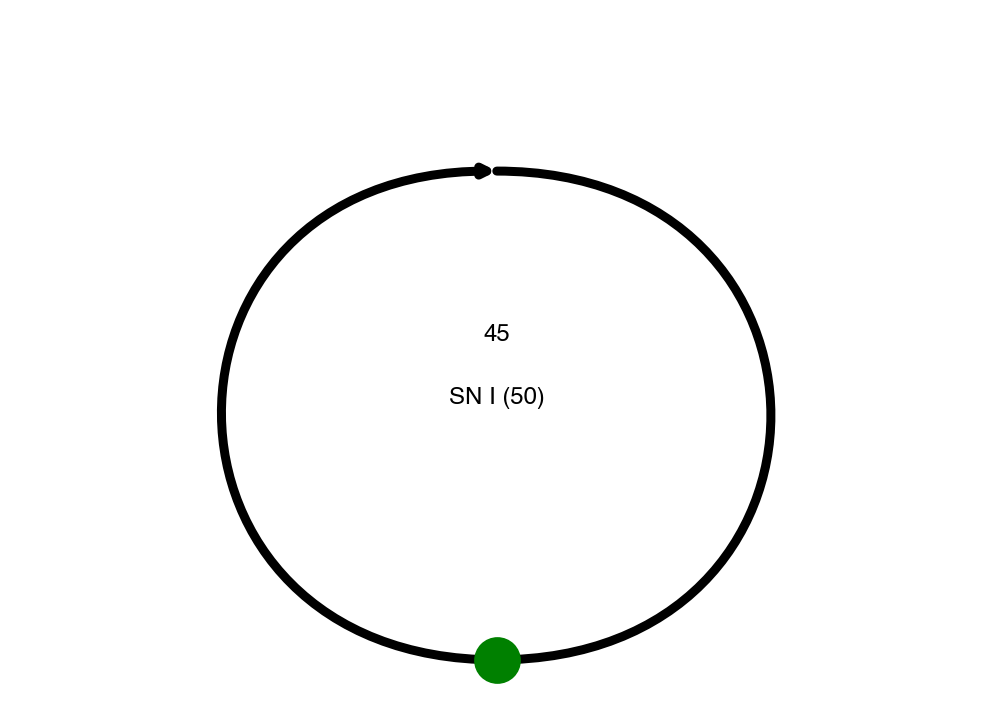

SN II


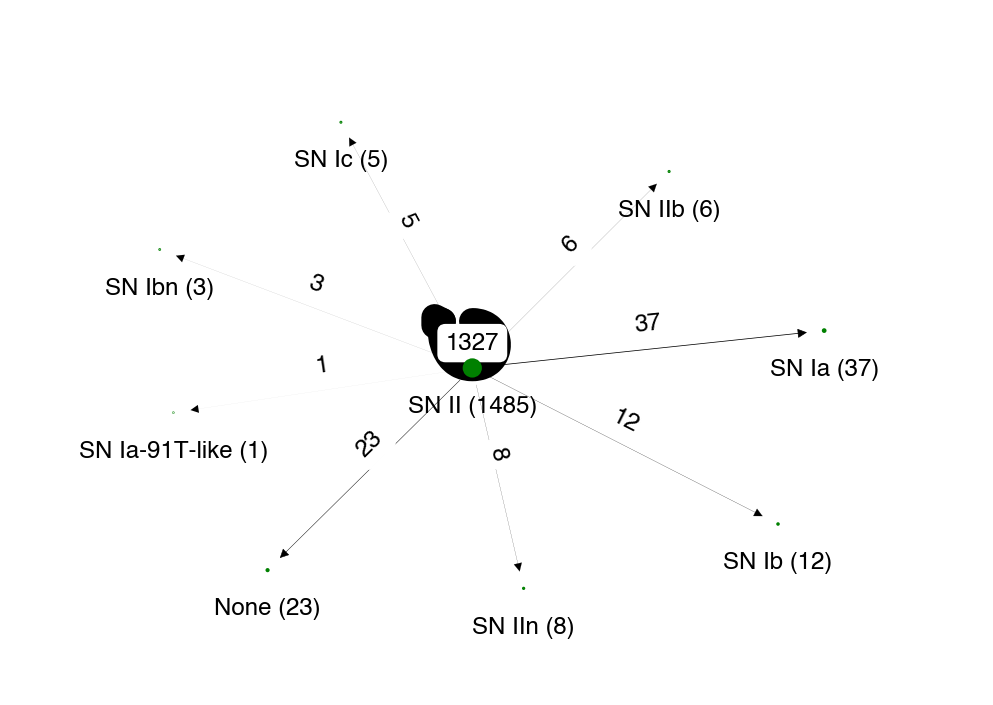

SN IIP


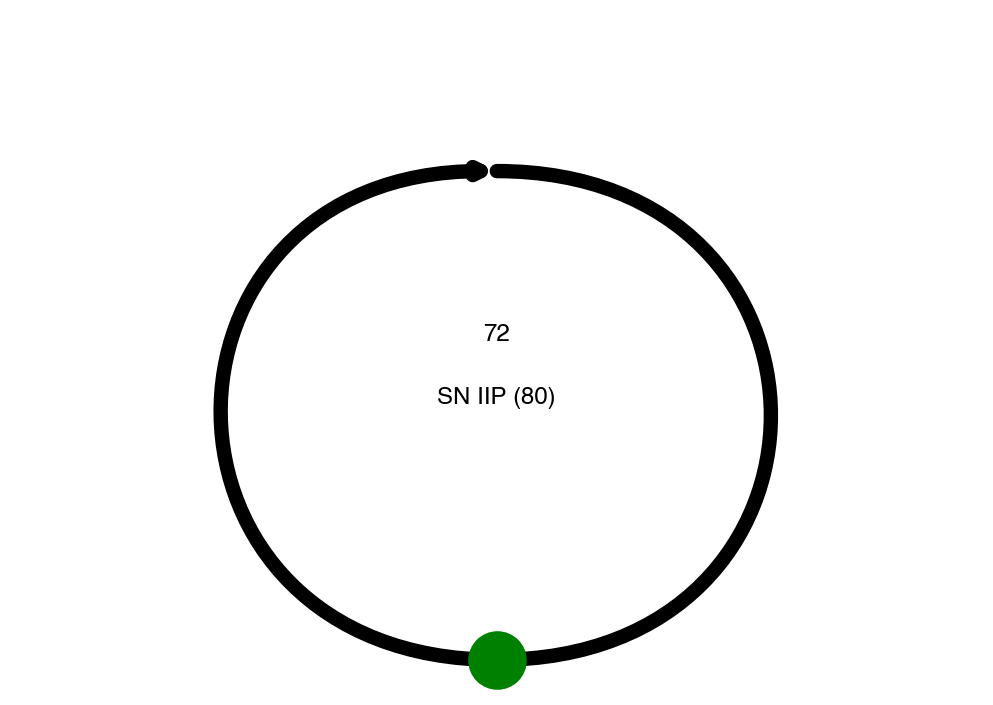

SN IIb


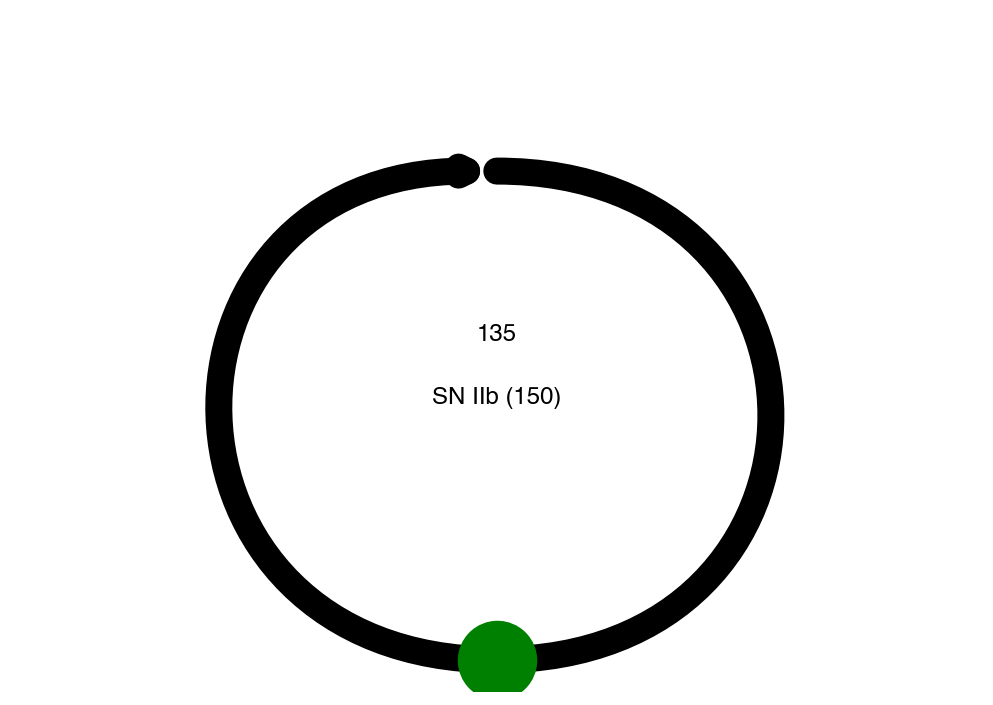

SN IIn


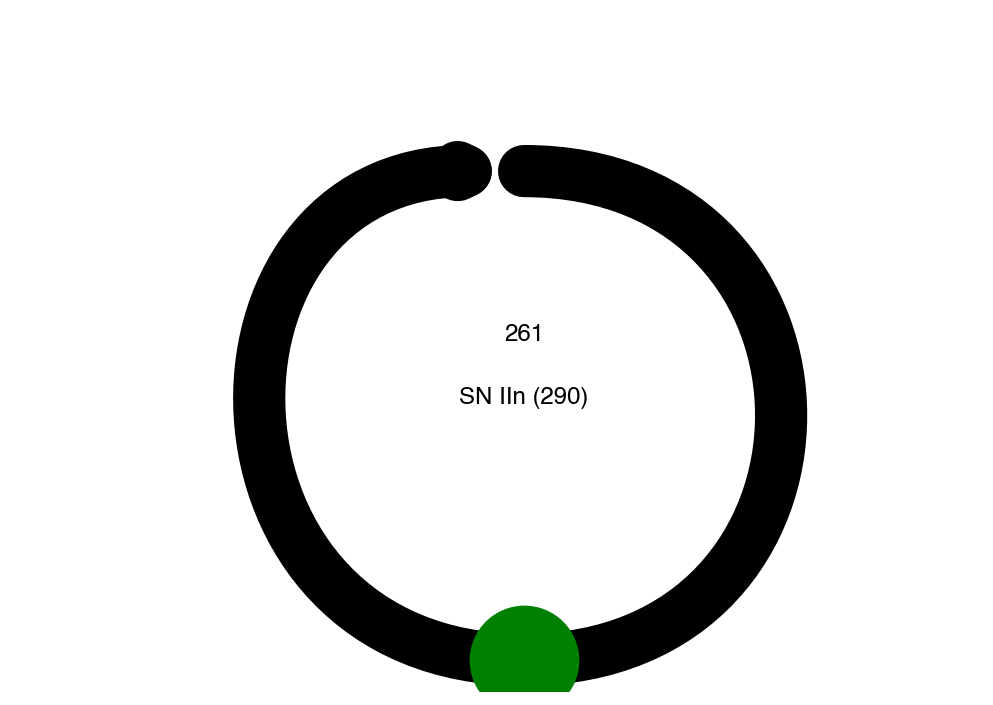

SN Ia


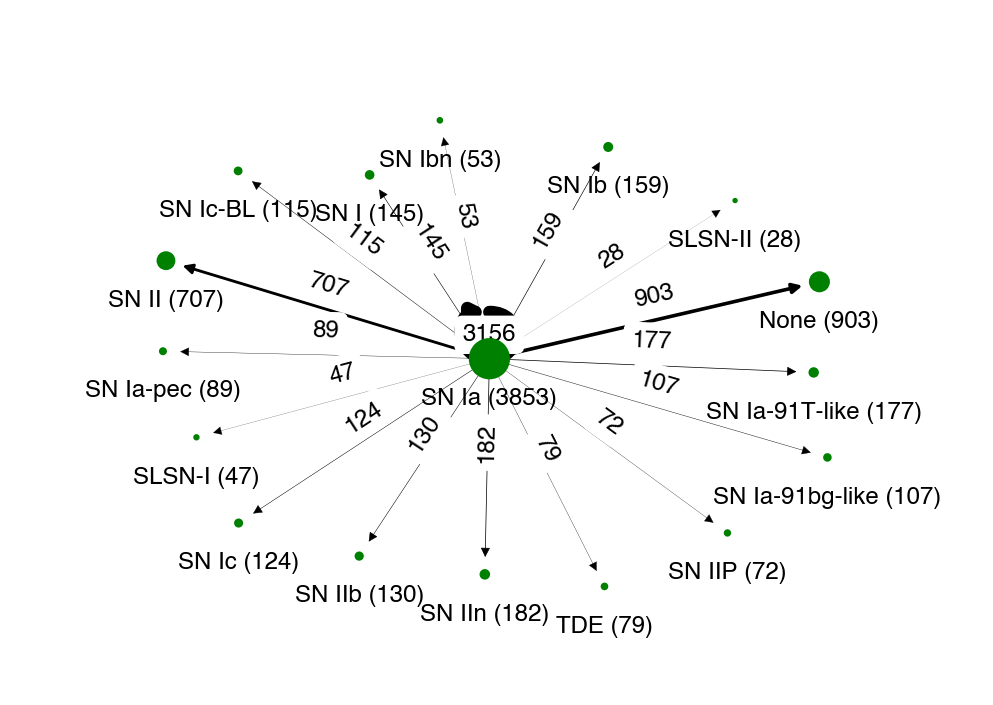

SN Ia-91T-like


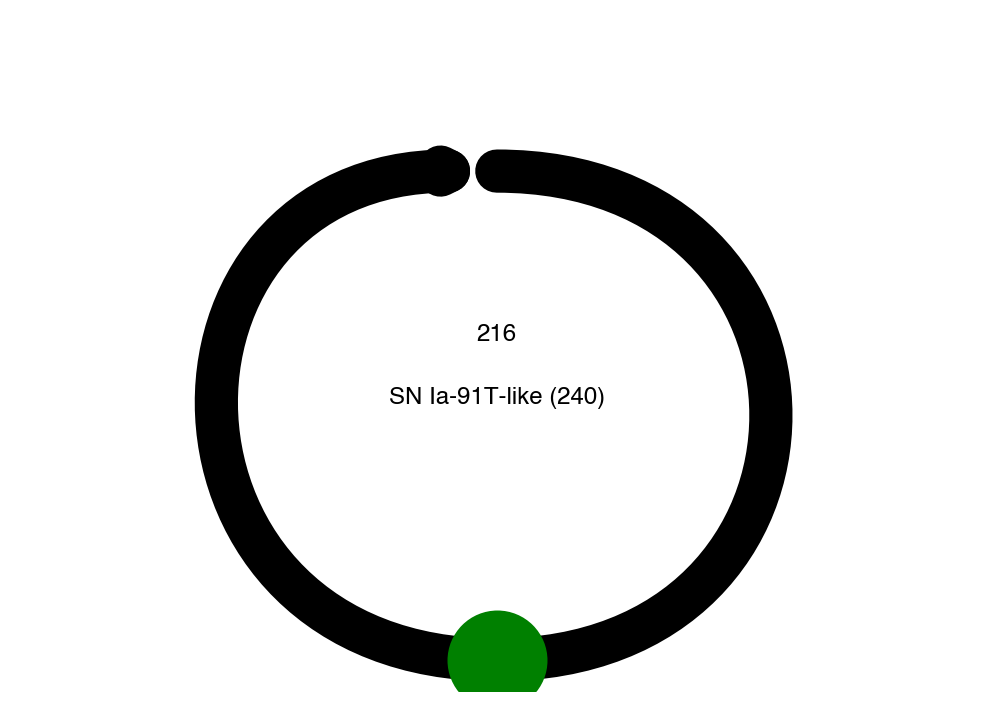

SN Ia-91bg-like


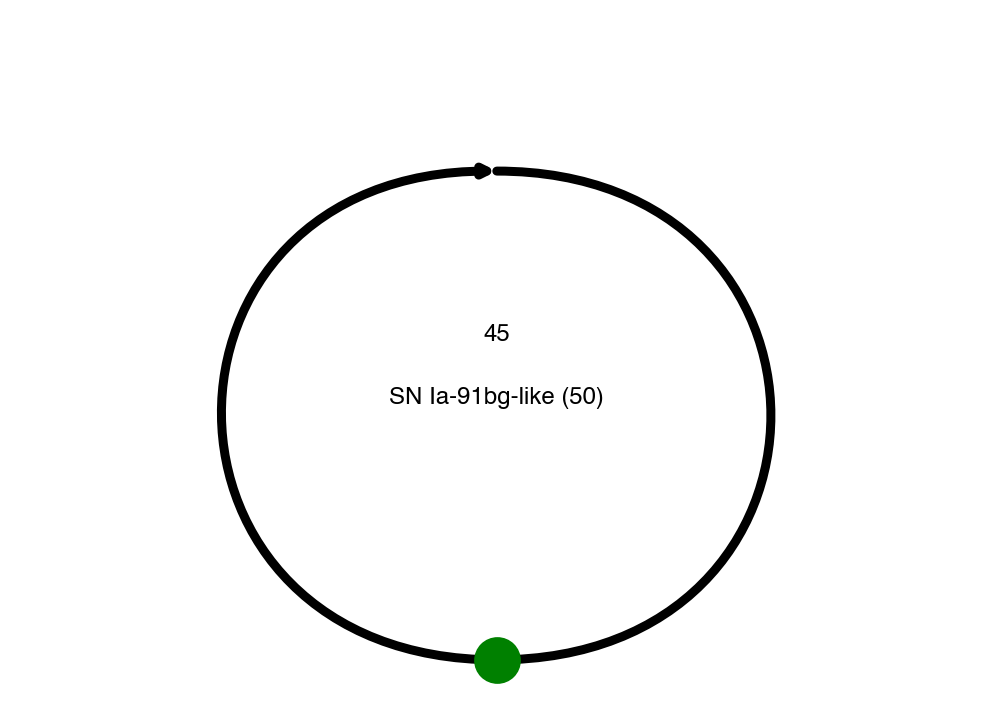

SN Ia-pec


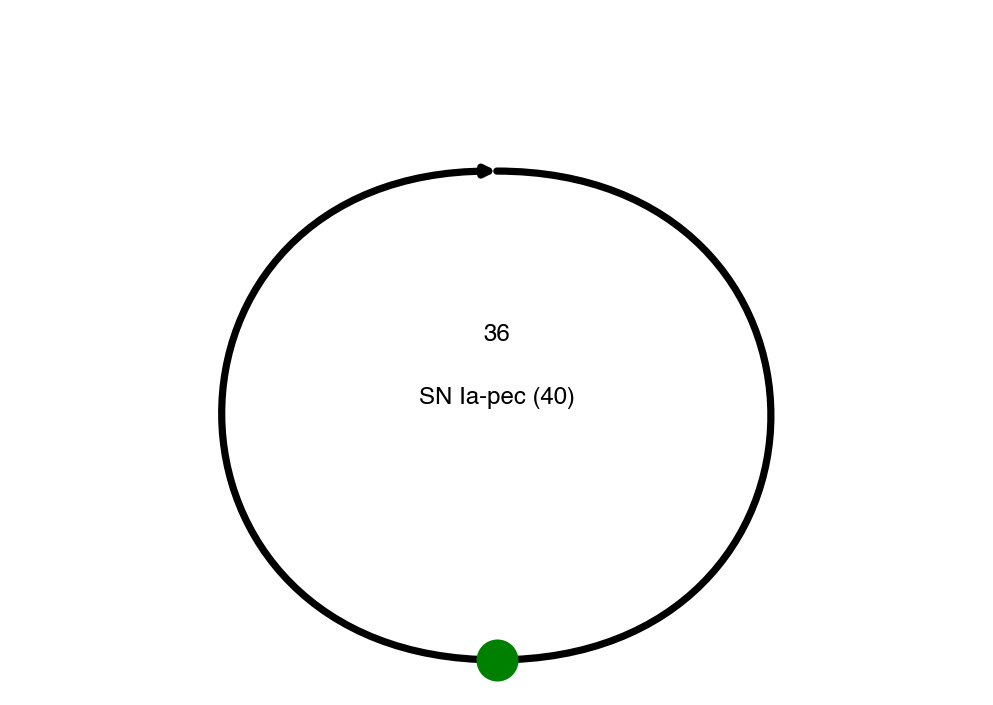

SN Ib


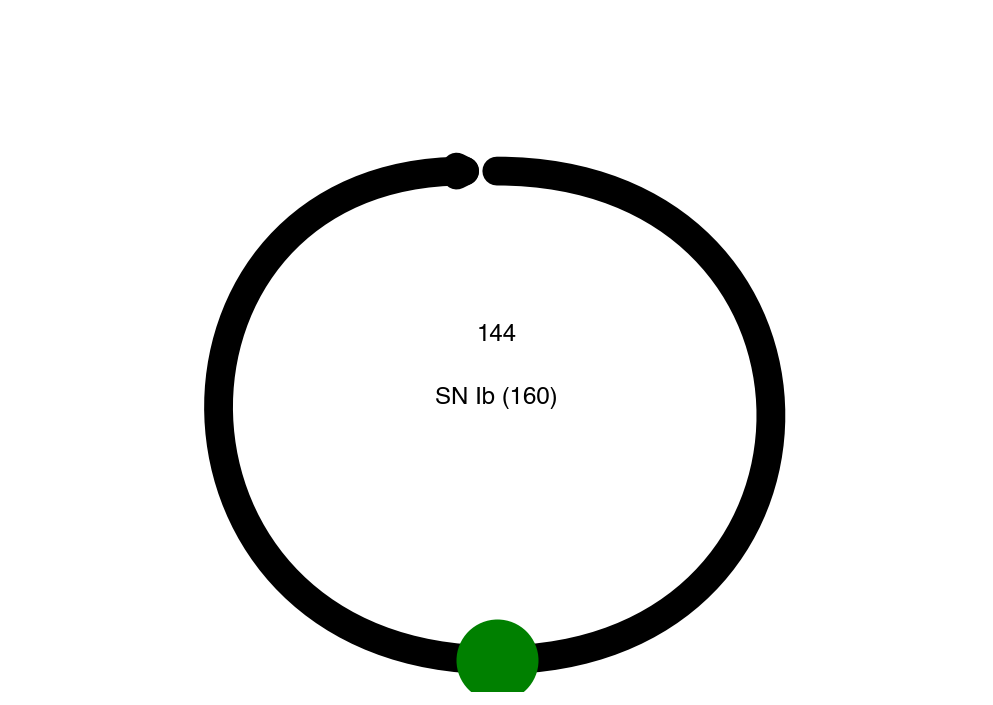

SN Ibn


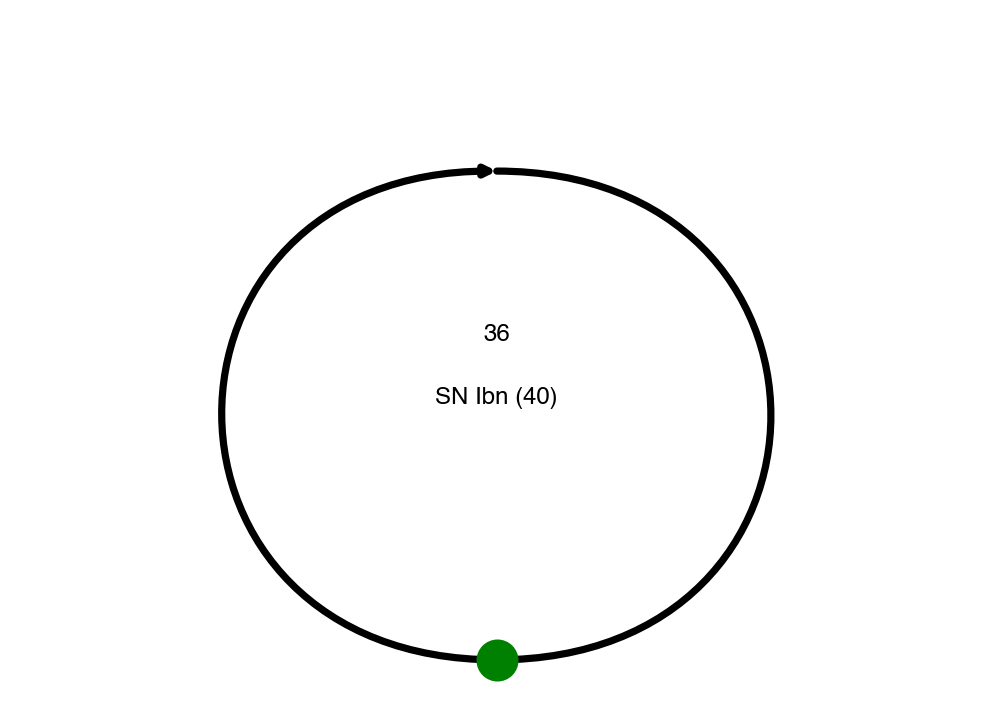

SN Ic


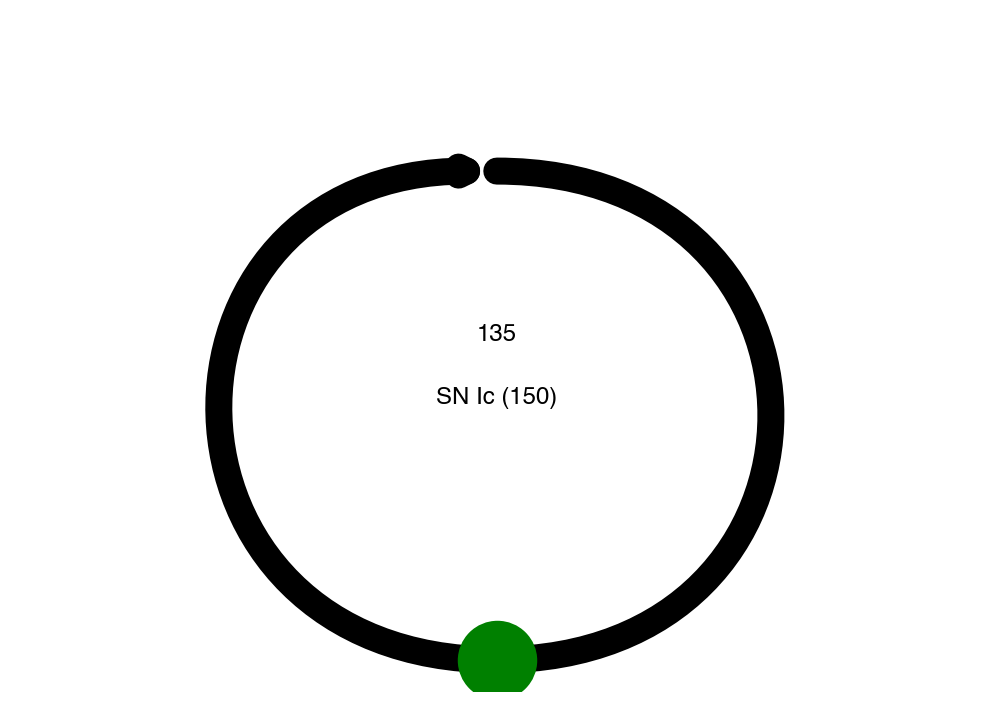

SN Ic-BL


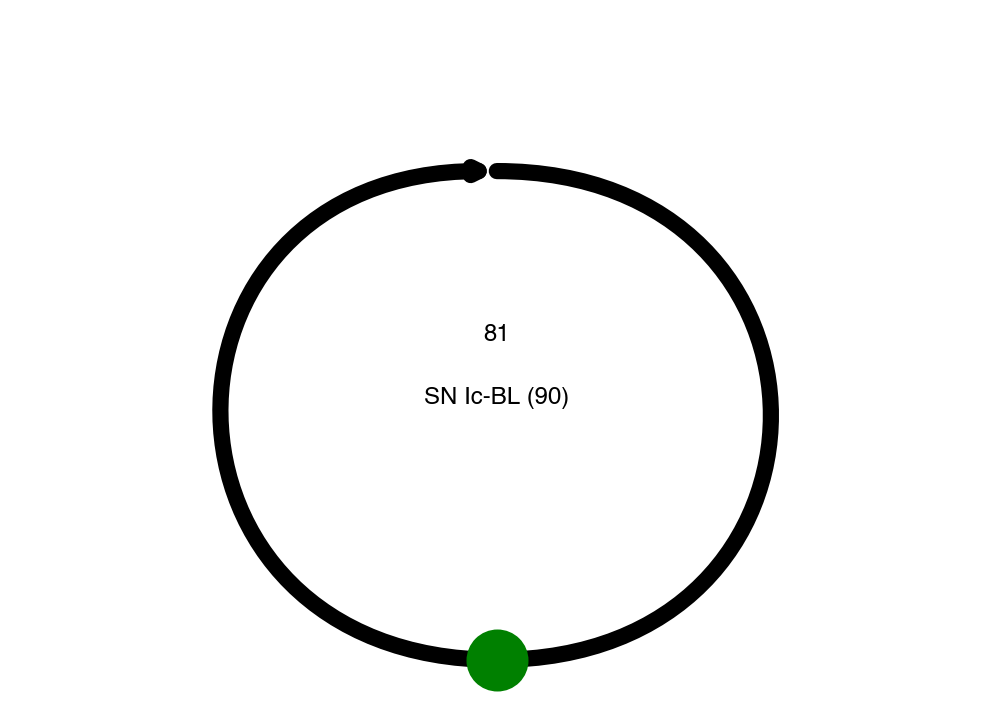

TDE


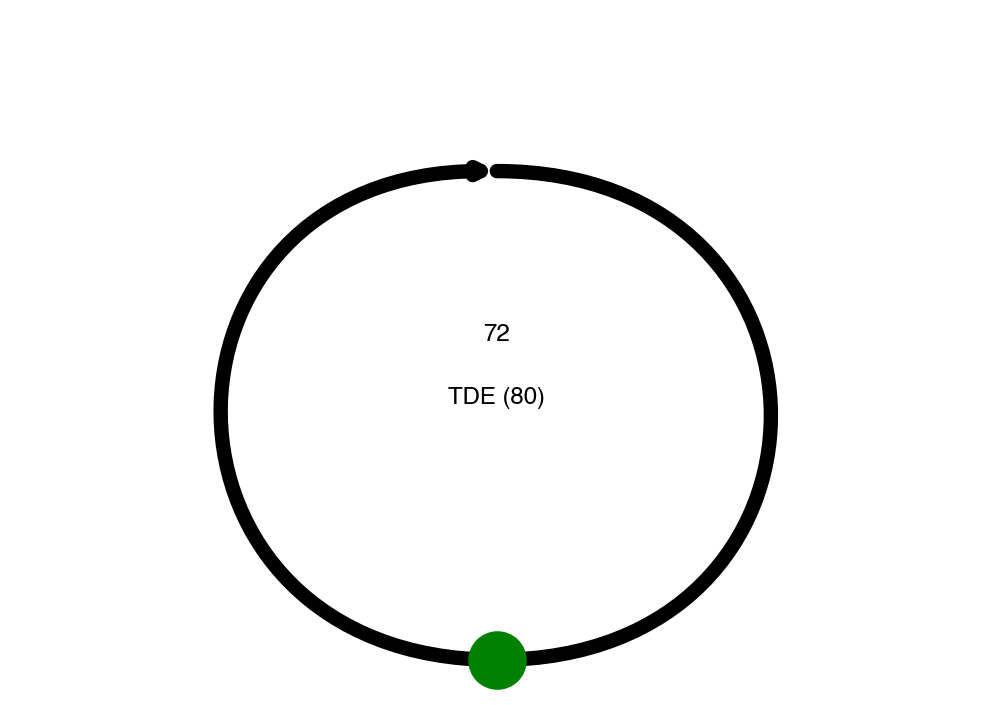

In [80]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

for cls in np.unique(graph_df['node']):
    print(cls)
    
    graph_df_cls = graph_df[graph_df.node == cls]


    # Create a sample dataframe with node and edge data
    df = graph_df_cls
    # Create a list of edges
    edges = [(row['node'], to) for _, row in df.iterrows() for to in row['neighbors']]

    # Create a network graph from the edges
    G = nx.DiGraph()
    G.add_edges_from(edges)

    # Compute the frequency of each unique connection
    edge_freq = {}
    for u, v in edges:
        key = (min(u, v), max(u, v))
        edge_freq[key] = edge_freq.get(key, 0) + 1

    # Add edge labels with frequency
    edge_labels = {}
    for u, v, d in G.edges(data=True):
        key = (min(u, v), max(u, v))
        #if edge_freq[key] >= 500:
        edge_labels[(u, v)] = str(edge_freq[key])

        # set edge widths based on frequency
        if cls == 'SN Ia': edge_widths = [int(edge_labels[edge])/500 for edge in edge_labels]
        elif cls == 'SN II': edge_widths = [int(edge_labels[edge])/100 for edge in edge_labels]
        elif cls == 'None': edge_widths = [int(edge_labels[edge])/1000 for edge in edge_labels]
        else: edge_widths = [int(edge_labels[edge])/10 for edge in edge_labels]

        # Scale the node sizes by the occurrences of the node
        #node_sizes = [10 * sum(1 for x in edges if x[0] == node or x[1] == node) for node in G.nodes()]
        #print(node_sizes)

        # explode the lists in the second column into separate rows
        df_expl = df.explode('neighbors')

        # group the data frame by the label column and count the number of unique values for each group
        unique_node_d = dict(Counter(df['node']))
        unique_neighbors_d = dict(Counter(df_expl['neighbors']))

        for key in unique_neighbors_d:
            if key in unique_node_d:
                unique_node_d[key] += unique_neighbors_d[key]
            else:
                unique_node_d[key] = unique_neighbors_d[key]

    node_count = unique_node_d
    
    if cls == 'SN Ia': node_sizes = [node_count[node] * 0.1 for node in G.nodes()]
    elif cls == 'SN II': node_sizes = [node_count[node] * 0.05 for node in G.nodes()]
    elif cls == 'None': node_sizes = [node_count[node] * 0.01 for node in G.nodes()]
    else: node_sizes = [node_count[node] * 10 for node in G.nodes()]
    #print(node_sizes)

    # Plot the graph
    pos = nx.spring_layout(G, seed=42)

    nx.draw_networkx_nodes(G, pos, node_color='g', node_size=node_sizes)
    nx.draw_networkx_edges(G, pos, edge_color='k', width=edge_widths)

    # Move the labels of the nodes down right below the node
    pos_labels = {}
    for key, value in pos.items():
        pos_labels[key] = (value[0], value[1] +.1)


    # # count the number of times of each node 
    # node_count = dict(Counter(graph_df_cv['node']))

    # # scale node sizes by frequency
    # node_sizes = [node_count[node] * 9 for node in G.nodes()]

    # create labels with node and count information
    node_labels = {node: f"\n\n\n\n\n{node} ({node_count[node]})" for node in G.nodes()}

    nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=12, font_color='black')

    nx.draw_networkx_edge_labels(G, pos_labels, edge_labels=edge_labels, font_size=12, font_color='black', font_weight='bold')

    cls = cls.replace(' ', '').replace('/','')
#     plt.axis('off')
#     plt.savefig(f'../figures/graphs/{suffix}_size_scaled_{cls}.jpg', dpi=300)
#     plt.show()

    plt.axis('off')
    axis = plt.gca()
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])
    plt.tight_layout()
    plt.savefig(f'../figures/graphs/{suffix}_size_scaled_{cls}.jpg', dpi=300)
    plt.show()


In [94]:
cls_df = full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ic']
full_ann_properties_cls_l = list(full_ann_properties_df['ann=0_ztfid'][cls_df.index])
cls_df['ztf_object_id'] = full_ann_properties_cls_l

full_ann_properties_cls_df = cls_df.set_index('ztf_object_id')
full_ann_properties_cls_df

<ipython-input-94-f64dbfb8229c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cls_df['ztf_object_id'] = full_ann_properties_cls_l


,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls
ztf_object_id,,,,,,,,,,
ZTF19aafmyow,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic
ZTF19aaxzdtw,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic
ZTF20abwxywy,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic
ZTF20abzjcdg,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic
ZTF20accoccp,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic
ZTF20aclnplo,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic
ZTF20actekrw,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic
ZTF20actpqgc,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic
ZTF20acueziy,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic


In [99]:
full_ann_properties_df[full_ann_properties_df['ann=0_tns_cls'] == "SN II"]

,ann=0_ztfid,ann=1_ztfid,ann=2_ztfid,ann=3_ztfid,ann=4_ztfid,ann=5_ztfid,ann=6_ztfid,ann=7_ztfid,ann=8_ztfid,ann=9_ztfid,...,ann=0_spec_z,ann=1_spec_z,ann=2_spec_z,ann=3_spec_z,ann=4_spec_z,ann=5_spec_z,ann=6_spec_z,ann=7_spec_z,ann=8_spec_z,ann=9_spec_z
5,ZTF18aacnlxz,ZTFabc41936,ZTFabc78941,ZTFabc62373,ZTFabc13436,ZTFabc58890,ZTFabc23438,ZTFabc15969,ZTFabc80388,ZTFabc63484,...,0.072475,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00
9,ZTF18aadsuxd,ZTFabc59087,ZTFabc64589,ZTFabc97439,ZTFabc65582,ZTFabc20912,ZTFabc39520,ZTFabc65749,ZTFabc78857,ZTFabc39552,...,0.030570,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00
18,ZTF18aaikcbb,ZTFabc24024,ZTFabc87454,ZTFabc07486,ZTFabc15726,ZTFabc49000,ZTFabc31501,ZTFabc20883,ZTFabc59186,ZTFabc70315,...,0.044000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00
85,ZTF18abaeqpf,ZTFabc21284,ZTFabc89149,ZTFabc21993,ZTFabc24136,ZTFabc78449,ZTFabc45889,ZTFabc39827,ZTFabc61567,ZTFabc57578,...,0.047500,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00
113,ZTF18abqyvzy,ZTFabc83457,ZTFabc10948,ZTFabc45160,ZTFabc01025,ZTFabc65241,ZTFabc53827,ZTFabc24817,ZTFabc88545,ZTFabc45432,...,0.014800,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3448,ZTF21abvdikq,ZTFabc70008,ZTFabc63501,ZTFabc32493,ZTFabc72711,ZTFabc89146,ZTFabc23109,ZTFabc81959,ZTFabc81351,ZTFabc84643,...,0.019000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00
3510,ZTF21abxmxut,ZTFabc66731,ZTFabc20932,ZTFabc73113,ZTFabc18047,ZTFabc57714,ZTFabc83629,ZTFabc25912,ZTFabc66681,ZTFabc79829,...,0.020000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00
3526,ZTF21abyahbi,ZTFabc37163,ZTFabc34481,ZTFabc98794,ZTFabc05130,ZTFabc59337,ZTFabc48032,ZTFabc77258,ZTFabc54170,ZTFabc91411,...,0.076684,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00
3537,ZTF21abzciqh,ZTFabc53539,ZTFabc75090,ZTFabc70331,ZTFabc04093,ZTFabc87246,ZTF20abfrrpw,ZTFabc83854,ZTFabc29140,ZTFabc29243,...,0.076000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00


In [100]:
full_ann_properties_df.loc[3537]

ann=0_ztfid      ZTF21abzciqh
ann=1_ztfid       ZTFabc53539
ann=2_ztfid       ZTFabc75090
ann=3_ztfid       ZTFabc70331
ann=4_ztfid       ZTFabc04093
ann=5_ztfid       ZTFabc87246
ann=6_ztfid      ZTF20abfrrpw
ann=7_ztfid       ZTFabc83854
ann=8_ztfid       ZTFabc29140
ann=9_ztfid       ZTFabc29243
ann=0_d                   0.0
ann=1_d               23.2813
ann=2_d               88.4968
ann=3_d               93.2369
ann=4_d              163.6608
ann=5_d              212.3556
ann=6_d              253.6061
ann=7_d              257.1743
ann=8_d              266.8957
ann=9_d              292.3807
ann=0_has_tns         Yes_TNS
ann=1_has_tns            Fake
ann=2_has_tns            Fake
ann=3_has_tns            Fake
ann=4_has_tns            Fake
ann=5_has_tns            Fake
ann=6_has_tns         Yes_TNS
ann=7_has_tns            Fake
ann=8_has_tns            Fake
ann=9_has_tns            Fake
ann=0_tns_cls           SN II
ann=1_tns_cls           SN II
ann=2_tns_cls           SN II
ann=3_tns_